# Projet 3: Concevez une application au service de la santé publique (cleaning)

Open Food Facts est une association à but non lucratif composée de volontaires qui fournit une base de données de produits alimentaires qui répertorie les ingrédients, les allergènes, la composition nutritionnelle et toutes les informations présentes sur les étiquettes des aliments. 

Toute la base de données est publiée sous forme de données ouvertes (open data) qui peuvent être utilisées par tous et pour tous usages.

La base de données contient:
- des **informations générales**: code barre du produit, url du produit sur le site d'Open Food Facts, contributeur qui a ajouté le produit pour la première fois, date de l'ajout et de la modification d'un produit, le nom du produit, sa quantité, son image
- des informations sur le **type du produit**: marque, catégorie, label
- des informations sur sa **provenance**: origine, lieu de transformation, pays,villes et magasins où sont proposés les produits
- des informations sur le type d'**emballage** du produit
- des informations sur la **composition** du produit: ingrédients, additifs, allergènes, nutriments, vitamines
- des **scores**: empreinte carbonne, nutriscore (défini par la FSA et sa version adaptée au marché français), grade de nutrition (de A à E)

Le nutriscore est attribué sur la base d’un score prenant en compte pour 100 gr ou 100 mL de produit, la teneur :
- en **nutriments et aliments à favoriser** (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- et en **nutriments à limiter** (énergie, acides gras saturés, sucres, sel)

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation.

Cette première partie de cleaning nous permettra d'assainir ce jeu de données en repérant les doublons, les variables aberrantes et en imputant les valeurs manquantes de manière appropriée.

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation du dataset](#dataset)
3. [Description des variables](#describe)
4. [Doublons](#doublons)
5. [Mots qui apparaissent le plus souvent dans le nom des variables](#words)
6. [Autres variables](#misc)
7. [Valeurs aberrantes](#outliers)
8. [Valeurs manquantes](#nan)  
9. [Sélection des variables en lien avec le choix d'application](#select) 

## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
import numpy as np
import pandas as pd
import collections
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from wordcloud import WordCloud

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
#plt.rcParams.keys()

In [3]:
# Configuration générale des graphiques
parameters = {'axes.labelsize': 13, 'axes.titlesize': 16, 'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

In [4]:
# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [5]:
#import warnings
#warnings.filterwarnings('ignore')

## Chargement et visualisation du dataset <a class="anchor" id="dataset"></a>

In [6]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t')

Lorsque l'on tente de charger directement le dataset, on obtient une erreur indiquant l'index des colonnes posant problème (type mixte). Afin de récupérer le nom des variables pour leur affecter un dtypes avant import, nous allons charger uniquement les 5 premières lignes et récupérer les colonnes (0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66):

In [7]:
#openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', nrows = 5)
#openfoodfacts

In [8]:
#liste_colonnes_pour_dtypes = [0,8,13,19,20,21,22,23,27,28,29,31,32,38,40,41,42,52,55,64,66]
#print(openfoodfacts.iloc[:,liste_colonnes_pour_dtypes].columns.tolist())

In [9]:
# Certaines colonnes ont des modalités de type différent, forçons le type en object
dtypes = {
    'code':object, 
    'abbreviated_product_name':object, 
    'packaging_text':object, 
    'origins':object,
    'origins_tags':object, 
    'origins_en':object, 
    'manufacturing_places':object,
    'manufacturing_places_tags':object, 
    'emb_codes':object, 
    'emb_codes_tags':object,
    'first_packaging_code_geo':object, 
    'cities_tags':object,
    'purchase_places':object,
    'allergens':object,
    'traces':object,
    'traces_tags':object, 
    'traces_en':object, 
    'ingredients_from_palm_oil_tags':object, 
    'ingredients_that_may_be_from_palm_oil_tags':object, 
    'brand_owner':object, 
    'ecoscore_grade_fr':object
}

In [10]:
# Chargement du dataset avec les bons dtypes
openfoodfacts = pd.read_csv('data\en.openfoodfacts.org.products.csv', sep = '\t', dtype=dtypes)

Nous allons créer une fonction qui permettra de savoir si lors d'un import futur, les variables correspondent à celles chargées à l'origine. Si ce n'est pas le cas, il faudra analyser les nouvelles variables afin de définir si elles apportent une information supplémentaire et peut être adapter le script.

In [11]:
#print(openfoodfacts.columns.tolist())

In [12]:
def controle_des_colonnes(dataset):
    '''Fonction qui permet de vérifier que toutes les colonnes ont bien été importées parmi la liste des 
    variables présentes lors de la phase de cleaning'''
    
    liste_colonnes = ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 
                      'last_modified_datetime', 'product_name', 'abbreviated_product_name', 'generic_name', 'quantity', 
                      'packaging', 'packaging_tags', 'packaging_text', 'brands', 'brands_tags', 'categories', 
                      'categories_tags', 'categories_en', 'origins', 'origins_tags', 'origins_en', 'manufacturing_places', 
                      'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 
                      'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 
                      'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 
                      'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 
                      'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 
                      'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 
                      'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 
                      'nutriscore_score', 'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2', 
                      'states', 'states_tags', 'states_en', 'brand_owner', 'ecoscore_score_fr', 'ecoscore_grade_fr', 
                      'main_category', 'main_category_en', 'image_url', 'image_small_url', 'image_ingredients_url', 
                      'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url', 'energy-kj_100g', 
                      'energy-kcal_100g', 'energy_100g', 'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g', 
                      '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g', '-capric-acid_100g', 
                      '-lauric-acid_100g', '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g', 
                      '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g', 
                      '-montanic-acid_100g', '-melissic-acid_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                      'omega-3-fat_100g', '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g', 
                      '-docosahexaenoic-acid_100g', 'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g', 
                      '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g', 'omega-9-fat_100g', 
                      '-oleic-acid_100g', '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g', 
                      '-erucic-acid_100g', '-nervonic-acid_100g', 'trans-fat_100g', 'cholesterol_100g', 
                      'carbohydrates_100g', 'sugars_100g', '-sucrose_100g', '-glucose_100g', '-fructose_100g', 
                      '-lactose_100g', '-maltose_100g', '-maltodextrins_100g', 'starch_100g', 'polyols_100g', 
                      'fiber_100g', 'soluble-fiber_100g', 'insoluble-fiber_100g', 'proteins_100g', 'casein_100g', 
                      'serum-proteins_100g', 'nucleotides_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 
                      'vitamin-a_100g', 'beta-carotene_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 
                      'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 
                      'vitamin-b9_100g', 'folates_100g', 'vitamin-b12_100g', 'biotin_100g', 'pantothenic-acid_100g', 
                      'silica_100g', 'bicarbonate_100g', 'potassium_100g', 'chloride_100g', 'calcium_100g', 
                      'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 
                      'fluoride_100g', 'selenium_100g', 'chromium_100g', 'molybdenum_100g', 'iodine_100g', 'caffeine_100g', 
                      'taurine_100g', 'ph_100g', 'fruits-vegetables-nuts_100g', 'fruits-vegetables-nuts-dried_100g', 
                      'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 
                      'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g', 'carbon-footprint_100g', 
                      'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 
                      'glycemic-index_100g', 'water-hardness_100g', 'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g', 
                      'inositol_100g', 'carnitine_100g']
    
    
    if dataset.columns.tolist() == liste_colonnes:
        print('Toutes les variables ont bien été chargées')
    
    else:
        print('Variable(s) non présente(s) dans le dataset:')
        print(set(liste_colonnes) - set(dataset.columns.tolist()))
        
        print('Variable(s) supplémentaires dans le dataset:')
        print(set(dataset.columns.tolist()) - set(liste_colonnes))

In [13]:
controle_des_colonnes(openfoodfacts)

Toutes les variables ont bien été chargées


In [14]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2053679 entries, 0 to 2053678
Columns: 187 entries, code to carnitine_100g
dtypes: float64(125), int64(2), object(60)
memory usage: 2.9+ GB


In [15]:
openfoodfacts.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,...,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/00000000000000225/jeunes-pousses-endives,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,NaN,NaN,NaN,NaN,endives,endives,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/00000000000003429145/l-casei,kiliweb,1630483911,2021-09-01T08:11:51Z,1630484064,2021-09-01T08:14:24Z,L.casei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,en:spain,Spain,"Leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene Lactobacidus casei), vitaminas (B6 y D).",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000000000031/cacao,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0

Regardons à présent le nombre de lignes et colonnes du dataset.

In [16]:
def shape_total_nan(dataframe):
    '''Fonction qui retourne le nombre de lignes, de variables, le nombre total de valeurs manquantes et
    le pourcentage associé'''
    missing = dataframe.isna().sum().sum()
    missing_percent = round(missing / (dataframe.shape[0] * dataframe.shape[1]) * 100, 2)
    
    print(f"Nombre de lignes: {dataframe.shape[0]}")
    print(f"Nombre de colonnes: {dataframe.shape[1]}")
    print(f"Nombre total de NaN du dataset: {missing}")
    print(f"% total de NaN du dataset: {missing_percent}%")   

In [17]:
shape_total_nan(openfoodfacts)

Nombre de lignes: 2053679
Nombre de colonnes: 187
Nombre total de NaN du dataset: 307558533
% total de NaN du dataset: 80.09%


Supprimons les variables composées à 99% de valeurs manquantes. Nous définissons un seuil assez bas pour le moment.

In [18]:
def min_fill_threshold(dataframe, min_threshold_percent):
    '''Fonction qui renvoie le dataframe supprimé des variables qui sont sous le seuil de remplissage
    indiqué en entrée'''
    return dataframe.loc[:, dataframe.isna().mean() <= ((100-min_threshold_percent)/100)]

In [19]:
openfoodfacts = min_fill_threshold(openfoodfacts, 1)

In [20]:
shape_total_nan(openfoodfacts)

Nombre de lignes: 2053679
Nombre de colonnes: 90
Nombre total de NaN du dataset: 108566833
% total de NaN du dataset: 58.74%


**Dataset original:**
- Nombre de lignes: 2 053 679
- Nombre de variables: 187: 125 float64, 2 int64 et 60 object
- 80.09% de valeurs manquantes dans le dataset

**Après suppression des colonnes contenant 99% de valeurs manquantes:**
- Nombre de colonnes: 90
- 58.74% de valeurs manquantes dans le dataset

## Description des variables <a class="anchor" id="describe"></a>

In [21]:
def describe_variables(data):
    ''' fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN) et les principales statistiques 
    pour les variables numériques (moyenne, médiane, distribution, variance, écart type, minimum, quartiles et 
    maximum)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 'Median', 'Skew', 'Kurtosis', 
                                 'Variance', 'Std', 'Min','25%','75%','Max'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        
        # Pour les variables de type 'int' ou 'float': on remplit toutes les colonnes
        if var_type == 'int' or var_type == 'float': 
            df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
                                          percent_count,missing, percent_missing,
                                          round(data[column].mean(),2),round(data[column].median(),2),
                                          round(data[column].skew(),2),round(data[column].kurtosis(),2),
                                          round(data[column].var(),2),round(data[column].std(),2),
                                          round(data[column].min(),2),round(data[column].quantile(0.25),2),
                                          round(data[column].quantile(0.75),2),data[column].max()]], 
                                        columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                                   '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 
                                                   'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min','25%',
                                                   '75%', 'Max']))
            
        
        
        # Pour les variables d'un autre type: on ne remplit que les variables de compte    
        else:            
            df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count,
                                          percent_count,missing, percent_missing,
                                          '','','','','','','','','','']], 
                                        columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                                   '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean', 
                                                   'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min', '25%', 
                                                   '75%', 'Max']))
            
    return df.reset_index(drop = True)

In [22]:
describe_variables(openfoodfacts)

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,code,object,00000000000000225,2053679,2053664,100.00,2053679,100.00,0,0.00,,,,,,,,,,
1,url,object,http://world-en.openfoodfacts.org/product/00000000000000225/jeunes-pousses-endives,2053679,2053666,100.00,2053679,100.00,0,0.00,,,,,,,,,,
2,creator,object,nutrinet-sante,2053679,14861,0.72,2053675,100.00,4,0.00,,,,,,,,,,
3,created_t,int64,1623855208,2053679,1799982,87.65,2053679,100.00,0,0.00,,,,,,,,,,
4,created_datetime,object,2021-06-16T14:53:28Z,2053679,1799982,87.65,2053679,100.00,0,0.00,,,,,,,,,,
5,last_modified_t,int64,1623855209,2053679,1613668,78.57,2053679,100.00,0,0.00,,,,,,,,,,
6,last_modified_datetime,object,2021-06-16T14:53:29Z,2053679,1613668,78.57,2053679,100.00,0,0.00,,,,,,,,,,
7,product_name,object,jeunes pousses,2053679,1276058,62.14,1970360,95.94,83319,4.06,,,,,,,,,,
8,generic_name,object,Blanquette de Volaille et son Riz,2053679,89427,4.35,123512,6.01,1930167,93.99,,,,,,,,,,
9,quantity,object,130 g,2053679,37648,1.83,517845,25.22,1535834,74.78,,,,,,,,,,


On repère déjà des redondances entre certaines variables catégorielles (packaging et packaging_tags ou categories, categories_tags et categories_en par exemple). Les statistiques de certaines variables numériques sont incohérentes. Nous les traiterons dans la partie sur les outliers.

## Doublons <a class="anchor" id="doublons"></a>

Il est important de vérifier que le dataset ne contienne pas de doublons. La variable "code" semble représenter la clé primaire de notre table. Vérifions dans un premier temps si cette variable contient plusieurs fois le même code. Ensuite nous vérifierons si un même produit existe plusieurs fois dans la base et adopterons une stratégie pour son traitement.  

### Doublons intégraux <a class="anchor" id="doublons_all"></a>

In [23]:
# Nombre de doublons intégraux
print(f"Doublons intégraux: {openfoodfacts.duplicated().sum()}")

Doublons intégraux: 4


In [24]:
# Suppression des doublons intégraux
openfoodfacts = openfoodfacts.drop_duplicates()

### Variable Code <a class="anchor" id="doublons_code"></a>

In [25]:
# Nombre de doublons sur la colonne code
print(f"Codes en doublons: {openfoodfacts.duplicated('code').sum()}")

Codes en doublons: 11


In [26]:
# Supprimons les lignes dupliquées qui ont le plus grand nombre de NaN par lignes
openfoodfacts['null_count'] = openfoodfacts.isnull().sum(1)

openfoodfacts = openfoodfacts.sort_values('null_count')\
       .drop_duplicates(subset = "code")\
       .sort_index()

In [27]:
# Suppression de la variable null_count
openfoodfacts.drop('null_count', axis='columns', inplace = True)

In [28]:
shape_total_nan(openfoodfacts)

Nombre de lignes: 2053664
Nombre de colonnes: 90
Nombre total de NaN du dataset: 108566097
% total de NaN du dataset: 58.74%


### Variable Product Name <a class="anchor" id="doublons_product"></a>

Dans un premier temps, afin d'éviter d'avoir des produits différents à cause de la casse, modifions toutes les modalités des colonnes de type object en minuscules.

In [29]:
liste_col_object = openfoodfacts.select_dtypes(include=['object']).columns.tolist()

for col in liste_col_object:
    openfoodfacts[col] = openfoodfacts[col].str.lower()

In [30]:
# Nombre de doublons sur la colonne product_name
print(f"Produits en doublons: {openfoodfacts.duplicated('product_name').sum()}")

Produits en doublons: 884163


Plus de 884 000 produits ont le même nom dans le dataset. Regardons quelques lignes afin de mieux comprendre.

In [31]:
# Liste des product_name dupliqués
liste_duplicated_products = openfoodfacts[openfoodfacts[
    'product_name'].duplicated()]['product_name'].tolist()

In [32]:
# Affichage des lignes dupliquées du dataset
openfoodfacts[openfoodfacts['product_name'].isin(
    liste_duplicated_products)].sort_values(by = 'product_name', ascending=True).head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,traces,traces_tags,traces_en,serving_size,serving_quantity,additives_n,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
1498917,6194001801354,http://world-en.openfoodfacts.org/product/6194001801354/energy-fruits-stil,kiliweb,1572616854,2019-11-01t14:00:54z,1635590230,2021-10-30t10:37:10z,#energy fruits,NaN,NaN,bouteille plastique,bouteille-plastique,stil,stil,"boissons,boissons avec sucre ajouté","en:beverages,en:sweetened-beverages","beverages,sweetened beverages",NaN,NaN,NaN,tunisie,tunisie,en:no-preservatives,en:no-preservatives,no preservatives,NaN,NaN,NaN,NaN,tunisie,NaN,en:tn,en:tunisia,tunisia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,e,NaN,beverages,sweetened beverages,"en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:origins-to-be-completed, en:categories-completed, en:brands-completed, en:packaging-completed, en:quantity-to-be-completed, en:product-name-completed, en:photos-to-be-validated, en:packaging-photo-to-be-selected, en:nutrition-photo-selected, en:ingredients-photo-to-be-selected, en:front-photo-selected, en:photos-uploaded","en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:origins-to-be-completed,en:categories-completed,en:brands-completed,en:packaging-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-validated,en:packaging-photo-to-be-selected,en:nutrition-photo-selected,en:ingredients-photo-to-be-selected,en:front-photo-selected,en:photos-uploaded","to be completed,nutrition facts completed,ingredients to be completed,expiration date to be completed,packaging code to be completed,characteristics to be completed,origins to be completed,categories completed,brands completed,packaging completed,quantity to be completed,product name completed,photos to be validated,packaging photo to be selected,nutrition photo selected,ingredients photo to be selected,front photo selected,photos uploaded",NaN,en:sweetened-beverages,sweetened beverages,https://images.openfoodfacts.org/images/products/619/400/180/1354/front_fr.3.400.jpg,https://images.openfoodfacts.org/images/products/619/400/180/1354/front_fr.3.200.jpg,NaN,NaN,https://images.openfoodfacts.org/images/products/619/400/180/1354/nutrition_fr.5.400.jpg,https://images.openfoodfacts.org/images/products/619/400/180/1354/nutrition_fr.5.200.jpg,NaN,47.0,197.0,0.0,0.0,NaN,NaN,NaN,NaN,11.64,11.0,NaN,0.05,0.00,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0
1498906,6194001801033,http://world-en.openfoodfacts.org/prod

In [33]:
def etiquette_h(ax):
    """Ajoute les étiquettes en haut de chaque barre sur un barplot horizontal.
    Arguments:
    ax (matplotlib.axes.Axes): objet matplotlib ocontenant les axes du plot à annoter."""
    
    for p in ax.patches:
        etiquette = '{:,.0f}'.format(p.get_width())
        width, height = p.get_width(),p.get_height()
        x = p.get_x() + width + 0.02
        y = p.get_y() + height / 2
        ax.annotate(etiquette,(x,y))

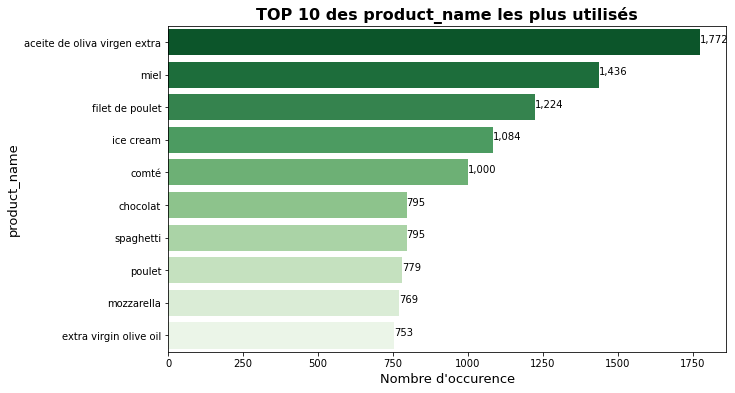

In [34]:
# Visualisation sous forme de countplot
plt.figure(figsize=(10,6))
ax = sns.countplot(y = 'product_name', data = openfoodfacts,
                   order = openfoodfacts['product_name'].value_counts().index[0:10],
                   palette = 'Greens_r')
plt.title('TOP 10 des product_name les plus utilisés')
plt.xlabel("Nombre d'occurence")
etiquette_h(ax);

Regardons plus en détail le product_name 'aceite de oliva virgen extra' et définissons une stratégie pour assainir la base.

In [35]:
test_duplicated_huile_olive = openfoodfacts[openfoodfacts['product_name'] \
                                                           == 'aceite de oliva virgen extra']
test_duplicated_huile_olive.head(10)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,traces,traces_tags,traces_en,serving_size,serving_quantity,additives_n,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,brand_owner,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,potassium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
186463,0066958057053,http://world-en.openfoodfacts.org/product/0066958057053/aceite-de-oliva-virgen-extra-castela-notti,kiliweb,1574193023,2019-11-19t19:50:23z,1607884155,2020-12-13t18:29:15z,aceite de oliva virgen extra,NaN,NaN,NaN,NaN,castela notti,castela-notti,"alimentos y bebidas de origen vegetal, alimentos de origen vegetal, aceites y grasas, productos del olivo, grasas vegetales, aceites vegetales, aceites de oliva, aceites de oliva virgen extra","en:plant-based-foods-and-beverages,en:plant-based-foods,en:fats,en:vegetable-fats,en:olive-tree-products,en:vegetable-oils,en:olive-oils,en:virgin-olive-oils,en:extra-virgin-olive-oils","plant-based foods and beverages,plant-based foods,fats,vegetable fats,olive tree products,vegetable oils,olive oils,virgin olive oils,extra-virgin olive oils",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spain,en:spain,spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fat and sauces,fats,"en:to-be-completed, en:nutrition-facts-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:categories-completed, en:brands-completed, en:packaging-to-be-completed, en:quantity-to-be-completed, en:product-name-completed, en:photos-to-be-validated, en:packaging-photo-to-be-selected, en:nutrition-photo-selected, en:ingredients-photo-to-be-selected, en:front-photo-selected, en:photos-uploaded","en:to-be-completed,en:nutrition-facts-completed,en:ingredients-to-be-completed,en:expiration-date-to-be-completed,en:packaging-code-to-be-completed,en:characteristics-to-be-completed,en:categories-completed,en:brands-completed,en:packaging-to-be-completed,en:quantity-to-be-completed,en:product-name-completed,en:photos-to-be-validated,en:packaging-photo-to-be-selected,en:nutrition-photo-selected,en:ingredients-photo-to-be-selected,en:front-photo-selected,en:photos-uploaded","to be completed,nutrition facts completed,ingredients to be completed,expiration date to be completed,packaging code to be completed,characteristics to be completed,categories completed,brands completed,packaging to be completed,quantity to be completed,product name completed,photos to be validated,packaging photo to be selected,nutrition photo selected,ingredients photo to be selected,front photo selected,photos uploaded",NaN,en:extra-virgin-olive-oils,extra-virgin olive oils,https://images.openfoodfacts.org/images/products/006/695/805/7053/front_es.3.400.jpg,https://images.openfoodfacts.org/images/products/006/695/805/7053/front_es.3.200.jpg,NaN,NaN,https://images.openf

On pourrait imaginer ne conserver qu'un produit par marque. Regardons tout d'abord le nombre d'huiles d'olive par marque.

In [36]:
test_duplicated_huile_olive.groupby('brands_tags')['product_name'].count().sort_values(ascending = False).head()

brands_tags
puerta-de-las-villas    13
hacendado               11
abril                    8
dcoop                    7
coosur                   7
Name: product_name, dtype: int64

Il existe bien plusieurs produits ayant le même nom pour une même marque. Parmis ces doublons, nous pourrions imaginer remplir les valeurs manquantes par le mode puis conserver le produit dont la date de mise à jour est la plus récente. Cependant, les codes barres étant différents, nous ne pouvons pas considérer que ce sont des doublons. 

## Mots qui apparaissent le plus souvent dans le nom des variables <a class="anchor" id="words"></a>

Dans un premier temps et afin de prendre connaissance avec les variables du jeu de données, récupérons les mots contenus dans le titre des variables qui reviennent le plus souvent.
Cette étape nous permettra de repérer une potentielle redondance entre les variables.

In [37]:
# Récupération des mots contenus dans les titres des colonnes (séparateur =  "_")
liste_mots_colonnes = [i.split('_') for i in openfoodfacts.columns] 

# Applatissement de la liste de listes
liste_mots_colonnes_flat = []

for item in liste_mots_colonnes:
    liste_mots_colonnes_flat += item

In [38]:
# J'affiche les 20 mots qui reviennent le plus dans les titres de colonnes
print(collections.Counter(liste_mots_colonnes_flat).most_common(20))

# J'enregistre tous les mots et le nombre associé dans une variable
most_common_columns_words = collections.Counter(liste_mots_colonnes_flat).most_common(len(liste_mots_colonnes_flat))

[('100g', 26), ('tags', 13), ('en', 8), ('url', 7), ('ingredients', 6), ('image', 6), ('packaging', 3), ('categories', 3), ('origins', 3), ('places', 3), ('labels', 3), ('countries', 3), ('traces', 3), ('additives', 3), ('n', 3), ('from', 3), ('palm', 3), ('oil', 3), ('states', 3), ('small', 3)]


In [39]:
# Passage sous dataframe afin de pouvoir visualiser les données sous forme de graphique (nb occurences >= 6)
most_common_columns_words = pd.DataFrame(most_common_columns_words, 
                                 columns = ['Mots', 'Nombre d\'occurences']).sort_values(by = 'Nombre d\'occurences', 
                                                                                         ascending=False)

most_common_columns_words = most_common_columns_words[most_common_columns_words["Nombre d\'occurences"] >= 6]

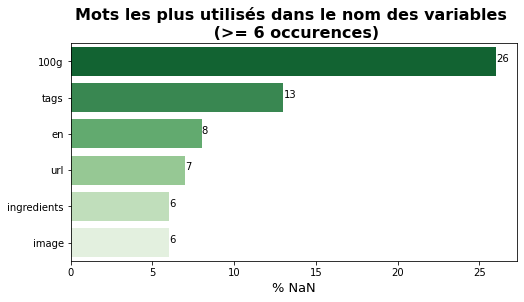

In [40]:
# Visualisation sous forme de barplot
plt.figure(figsize=(8, 4))
ax = sns.barplot(y = 'Mots', x = 'Nombre d\'occurences', data = most_common_columns_words, palette = 'Greens_r')
plt.title("Mots les plus utilisés dans le nom des variables \n (>= 6 occurences)")
plt.ylabel("")
plt.xlabel("% NaN")
etiquette_h(ax);

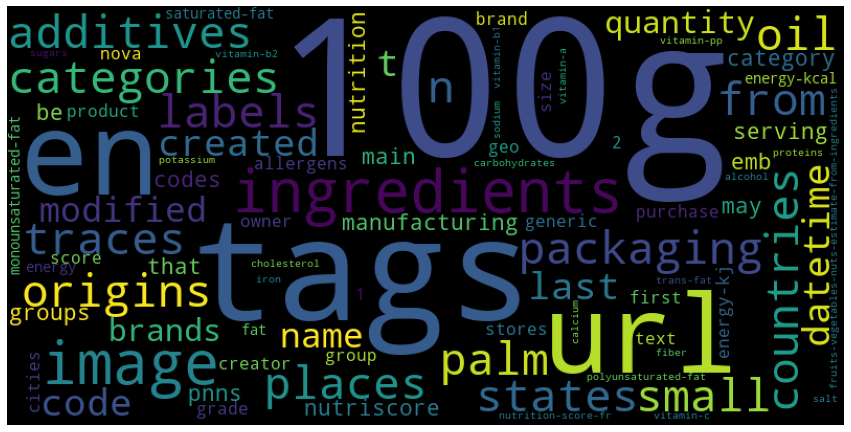

In [41]:
# Création d'un nuage de mots

# Conversion de la liste en dictionnaire valeurs / occurences
word_cloud_dict = Counter(liste_mots_colonnes_flat)
wordcloud = WordCloud(width = 800, height = 400).generate_from_frequencies(word_cloud_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off");

Nous allons analyser les variables qui ont le même préfixe afin de commencer à supprimer les variables qui apportent la même information. Ensuite, nous passerons en revue les autres variables afin de savoir lesquelles sélectionner dans notre dataset final. Ce passage en revue des différents variables va nous permettre de mieux connaitre le jeu de données et d'affiner notre projet en lien avec l'alimentation. Il pourra également permettre de compléter certaines valeurs non remplies.

### 100g

Les variables qui se terminent par _100g correspondent à la quantité de nutriments (en g ou kj pour l'énergie) pour 100g ou 100 ml de produit. Logiquement ces variables devraient être de type float.

In [42]:
# Liste des colonnes qui se terminent par _100g
col_100g = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_100g')].columns.tolist()
print(col_100g)

['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'potassium_100g', 'calcium_100g', 'iron_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g']


In [43]:
# On downcast les variables en float32 pour réduire la mémoire
for col in col_100g:
    openfoodfacts[col] = openfoodfacts[col].astype('float32')

In [44]:
openfoodfacts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2053664 entries, 0 to 2053678
Data columns (total 90 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   code                                                   object 
 1   url                                                    object 
 2   creator                                                object 
 3   created_t                                              int64  
 4   created_datetime                                       object 
 5   last_modified_t                                        int64  
 6   last_modified_datetime                                 object 
 7   product_name                                           object 
 8   generic_name                                           object 
 9   quantity                                               object 
 10  packaging                                              object 
 11

In [45]:
# Dtypes des variables qui se terminent par _100g et qui ne sont pas de type float
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_100g)].select_dtypes(exclude = ['float32']).dtypes

Series([], dtype: object)

Toutes ces variables sont bien au format float. En regardant la liste des colonnes, on repère des variables qui pourraient apporter la même information ou qui rentrent dans la composition d'une autre variable et qui ne devraient donc pas être sommées. Nous traiterons ce point dans la partie sur les valeurs aberrantes.

### tags

Les variables qui se terminent par _tags sont des variables qualitatives (packaging, marques, catégories etc). Elles doivent être de type "object".

In [46]:
# Liste des colonnes qui se terminent par _tags
col_tags = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_tags')].columns.tolist()
print(col_tags)

['packaging_tags', 'brands_tags', 'categories_tags', 'origins_tags', 'manufacturing_places_tags', 'labels_tags', 'emb_codes_tags', 'cities_tags', 'countries_tags', 'traces_tags', 'additives_tags', 'ingredients_that_may_be_from_palm_oil_tags', 'states_tags']


In [47]:
# On cast les variables en str
for col in col_tags:
    openfoodfacts[col] = openfoodfacts[col].astype("object")

In [48]:
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_tags)].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

Toutes ces variables ont bien le dtype objet. A partir du préfixe des variables se terminant par _tags, tentons de récupérer les variables associées afin de s'assurer qu'elles ne sont pas redondantes. 

In [49]:
# Pour chaque colonne se terminant par _tags, je supprime cette mention pour n'avoir que le préfixe
liste_col_tags_prefixe = [i.replace('_tags', '') for i in openfoodfacts.iloc[
    :,openfoodfacts.columns.isin(col_tags)].columns.unique().tolist()]

print(f'Préfixes des colonnes se terminant par _tags: {liste_col_tags_prefixe}')

Préfixes des colonnes se terminant par _tags: ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'cities', 'countries', 'traces', 'additives', 'ingredients_that_may_be_from_palm_oil', 'states']


In [50]:
# Fusion des 2 listes + tri par ordre alphabétique
liste_col_tags = liste_col_tags_prefixe + col_tags
liste_col_tags.sort()

In [51]:
print(f'Colonnes + colonnes associées _tags:\n\n {liste_col_tags}')

Colonnes + colonnes associées _tags:

 ['additives', 'additives_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'cities', 'cities_tags', 'countries', 'countries_tags', 'emb_codes', 'emb_codes_tags', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'labels', 'labels_tags', 'manufacturing_places', 'manufacturing_places_tags', 'origins', 'origins_tags', 'packaging', 'packaging_tags', 'states', 'states_tags', 'traces', 'traces_tags']


Automatisation des étapes précédentes.

In [52]:
def liste_col_endswith(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_ends_keyword = dataframe.iloc[:,(dataframe.columns.str.endswith(
    keyword))].columns.unique().tolist()
    
    liste_col_keyword = liste_col_keyword_prefixe + liste_col_ends_keyword
    liste_col_keyword.sort()
    
    return liste_col_keyword

In [53]:
liste_col_tags = liste_col_endswith(openfoodfacts, 'tags')

In [54]:
def describe_variables_light(data):
    '''Fonction qui prend un dataframe en entrée, et retourne un récapitulatif qui contient le nom des variables, 
    leur type, un exemple de modalité, le nombre total de lignes, le nombre et pourcentage de valeurs distinctes, 
    le nombre et pourcentage de valeurs non manquantes et de valeurs manquantes (NaN)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', '% distinct', 
                                 'Not NaN', '% Not NaN', 'NaN', '% NaN'])
    
    # Pour chaque colonne du dataframe
    for column in data.columns:
        
        # Définition des variables
        var_type = data[column].dtypes # type de la variable (object, float, int...)
        example = data[data[column].notna()][column].iloc[0] # premier élément notNA
        #example = [data[data[column].notna()][column].iloc[0] if data[column].isna().sum() != len(data[column]) else 0]
        nb_raw = len(data[column]) # nombre total de lignes
        count = len(data[column])- data[column].isna().sum() # nombre de valeurs non manquantes
        percent_count = round(data[column].notnull().mean(),4)*100 # % de valeurs non manquantes
        distinct = data[column].nunique() # nombre de modalités que peut prendre la variable
        percent_distinct = round(data[column].nunique()/len(data[column]),4)*100 # % de valeurs distinctes
        missing = data[column].isna().sum() # nombre de valeurs manquantes
        percent_missing = round(data[column].isna().mean(),4)*100 # % de valeurs manquantes
        
        
        df = df.append(pd.DataFrame([[column, var_type, example, nb_raw, distinct, percent_distinct, count, 
                                      percent_count,missing, percent_missing]], 
                                    columns = ['Variable name', 'Variable type', 'Example', 'Raws', 'Distinct', 
                                               '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN']))
        
    return df.reset_index(drop = True)

In [55]:
describe_variables_light(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,packaging,object,"barquette,plastique",2053664,49978,2.43,315928,15.38,1737736,84.62
1,packaging_tags,object,"barquette,plastique",2053664,46485,2.26,315888,15.38,1737776,84.62
2,brands,object,endives,2053664,153249,7.46,1050587,51.16,1003077,48.84
3,brands_tags,object,endives,2053664,141427,6.89,1050518,51.15,1003146,48.85
4,categories,object,"epicerie, condiments, sauces, moutardes",2053664,116582,5.68,945138,46.02,1108526,53.98
5,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053664,72802,3.54,945130,46.02,1108534,53.98
6,origins,object,spain,2053664,13022,0.63,88286,4.30,1965378,95.70
7,origins_tags,object,en:spain,2053664,11428,0.56,88156,4.29,1965508,95.71
8,manufacturing_places,object,bénivay-ollon,2053664,27437,1.34,128420,6.25,1925244,93.75
9,manufacturing_places_tags,object,benivay-ollon,2053664,25973,1.26,128360,6.25,1925304,93.75


In [56]:
def completion_distinct_plots(data):
    ''' fonction qui prend un dataframe en entrée et retourne 2 diagrammes en barres représentant le pourcentage 
    de données manquantes et le pourcentage de données distinctes du dataset. Cette fonction nécessite que
    soit chargée auparavant la fonction describe_variables '''   
    
    # Initialisation de la grille avec 1 ligne et 2 colonnes
    fig = plt.figure(figsize=(15,7), constrained_layout=True)
    gs = GridSpec(nrows=1, ncols=2, figure=fig)

    # Premier graphique
    ax1 = fig.add_subplot(gs[0,0]) # emplacement dans la grille
    ax1 = sns.barplot(y = 'Variable name', x = '% NaN', data = describe_variables_light(data), palette = 'Greens_r')
    plt.title("% NaN")
    plt.ylabel("")
    plt.xlabel("% NaN")
    etiquette_h(ax1)
        

# Deuxième graphique
    ax2 = fig.add_subplot(gs[0,1]) # emplacement dans la grille
    ax2 = sns.barplot(y = 'Variable name', x = '% distinct', data = describe_variables_light(data), palette = 'Greens_r')
    plt.title("% valeurs distinctes")
    plt.ylabel("")
    plt.xlabel("% distinct")
    etiquette_h(ax2);

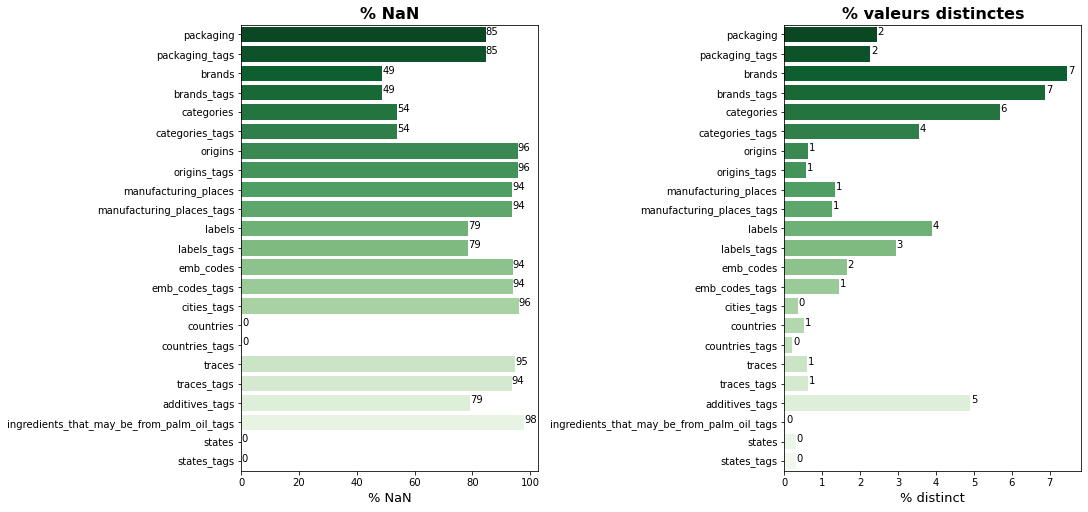

In [57]:
completion_distinct_plots(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_tags)])

Nous remarquons que les variables se terminant par _tags comportent souvent le même % de NaN que la variable associée mais le % de valeurs distinctes est quant à lui inférieur. Il semble être plus intéressant de conserver les variables se terminant par _tags et de supprimer les variables associées afin d'éviter la redondance d'information. De plus le site openfoodfacts nous indique que les variables _tags sont normalisées. Regardons quelques exemples avant de supprimer toutes les variables associées à celles se terminant par _tags.

In [58]:
openfoodfacts[~openfoodfacts['brands'].isnull()][['brands', 'brands_tags']].sample(10)

,brands,brands_tags
894537,delpierre,delpierre
1149806,kéferment,keferment
767305,gerblé,gerble
1830887,alipende,alipende
1433741,zahra,zahra
1991284,lipton,lipton
979322,candia,candia
470685,target corporation,target-corporation
100750,progresso,progresso
1026001,auchan,auchan


In [59]:
openfoodfacts[~openfoodfacts['categories'].isnull()][['categories', 'categories_tags']].sample(10)

,categories,categories_tags
866659,"produits laitiers, laits, produits de montagne, laits entiers, laits de montagne","en:dairies,en:milks,en:mountain-products,en:whole-milks,en:mountain-milks"
572221,cassoulet au magret de canard,fr:cassoulet-au-magret-de-canard
770414,"biscuits et gâteaux,gâteaux,donuts","en:biscuits-and-cakes,en:cakes,en:doughnuts"
438005,"snacks, sweet snacks, confectioneries","en:snacks,en:sweet-snacks,en:confectioneries"
392199,"biscuits and cakes, cakes, dietary supplements, bodybuilding supplements, chocolate cakes, brownies, protein bars","en:biscuits-and-cakes,en:cakes,en:dietary-supplements,en:bodybuilding-supplements,en:chocolate-cakes,en:brownies,en:protein-bars"
661752,"viandes, volailles, poulets, volailles cuites, escalopes de poulet","en:meats,en:poultries,en:chickens,en:cooked-poultries,en:chicken-cutlets"
1181651,"spreads, salted spreads, tapenades, en:plant-based-spreads","en:plant-based-foods-and-beverages,en:plant-based-foods,en:spreads,en:salted-spreads,en:plant-based-spreads,en:tapenades"
41400,"plant-based foods and beverages, plant-based foods, fruits and vegetables based foods, frozen foods, vegetables based foods, frozen plant-based foods, frozen vegetables","en:plant-based-foods-and-beverages,en:plant-based-foods,en:fruits-and-vegetables-based-foods,en:frozen-foods,en:vegetables-based-foods,en:frozen-plant-based-foods,en:frozen-vegetables"
889785,"produits laitiers, produits fermentés, produits laitiers fermentés, yaourts, yaourts aux fruits, yaourts aux fruits avec morceaux, yaourts aux fruits de la passion","en:dairies,en:fermented-foods,en:fermented-milk-products,en:yogurts,en:fruit-yogurts,en:fruit-yogurts-with-fruit-chunks,fr:yaourts-aux-fruits-de-la-passion"
803061,"boissons, boissons alcoolisées, vins, vins rosés, vins aromatisés","en:beverages,en:alcoholic-beverages,en:wines,en:rose-wines,en:flavoured-wines"


In [60]:
openfoodfacts[~openfoodfacts['labels'].isnull()][['labels', 'labels_tags']].sample(10)

,labels,labels_tags
612715,nutriscore,en:nutriscore
1768688,en:gluten-free,en:gluten-free
1554756,en:made-in-germany,en:made-in-germany
1020987,produit en braille,en:in-braille
1533010,no recomendado a niños menores de 3 años,"en:not-advised-for-specific-people,en:not-recommended-for-children-under-3-years"
1039854,"sans arômes artificiels, sans conservateurs","en:no-artificial-flavors,en:no-preservatives"
1120348,bio,en:organic
935472,"bio, bio européen, agriculture non ue, agriculture ue, agriculture ue/non ue, fr-bio-01, ab agriculture biologique","en:organic,en:eu-organic,en:non-eu-agriculture,en:eu-agriculture,en:eu-non-eu-agriculture,en:fr-bio-01,fr:ab-agriculture-biologique"
1629582,en:it-bio-009,"en:organic,en:eu-organic,en:it-bio-009"
123919,point vert,en:green-dot


Les variables semblent bien redondantes entre elles. Nous remarquons également que les variables se terminant par _tags semblent être le plus souvent traduites en anglais. Nous décidons de garder ces dernières.

In [61]:
liste_col_suppr = openfoodfacts.iloc[:,(openfoodfacts.columns.isin(liste_col_tags)) & 
                                        (~openfoodfacts.columns.str.endswith('_tags'))].columns.unique().tolist()
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

Liste des variables à supprimer: 

 ['packaging', 'brands', 'categories', 'origins', 'manufacturing_places', 'labels', 'emb_codes', 'countries', 'traces', 'states']


In [62]:
# Suppression des variables sans suffixe _tags
openfoodfacts = openfoodfacts.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 80


### en

La documentation nous indique que ces variables sont la traduction des variables _tags dans la langue indiquée. Elles doivent être de type "object".

In [63]:
# Liste des colonnes qui se terminent par _en
col_en = openfoodfacts.iloc[:,openfoodfacts.columns.str.endswith('_en')].columns.tolist()
print(col_en)

['categories_en', 'origins_en', 'labels_en', 'countries_en', 'traces_en', 'additives_en', 'states_en', 'main_category_en']


In [64]:
# On cast les variables en str
for col in col_en:
    openfoodfacts[col] = openfoodfacts[col].astype("object")

In [65]:
openfoodfacts.iloc[:,openfoodfacts.columns.isin(col_en)].select_dtypes(exclude = ['object']).dtypes

Series([], dtype: object)

In [66]:
print(liste_col_endswith(openfoodfacts, 'en'))

['additives', 'additives_en', 'categories', 'categories_en', 'countries', 'countries_en', 'labels', 'labels_en', 'main_category', 'main_category_en', 'origins', 'origins_en', 'states', 'states_en', 'traces', 'traces_en']


On retrouve dans cette liste les préfixes des variables qui se terminent par _tags. Lorsque l'on applique la fonction précédente on ne récupère que le préfixe et la variable associée. Il faudrait en fait récupérer tous les préfixes et regarder les variables associées: _tags, _en etc. Améliorons la fonction.

In [67]:
def liste_col_prefixe(dataframe, keyword):
    ''' Fonction qui permet de récupérer le préfixe des colonnes se terminant par un mot clef et qui retourne une liste
    de ces variables et des variables associées qui contiennent le préfixe. L'objectif est de s'assurer que ces variables
    n'apportent pas la même information.'''
    
    liste_col_keyword_prefixe = [i.replace(f'_{keyword}', '') for i in dataframe.iloc[
    :,dataframe.columns.str.endswith(keyword)].columns.unique().tolist()]
    
    liste_col_select = dataframe.iloc[:, dataframe.columns.str.startswith(
        tuple(liste_col_keyword_prefixe))].columns.unique().tolist()
    
    liste_col_select.sort()
                                      
    return dataframe.iloc[:,dataframe.columns.isin(liste_col_select)].columns

In [68]:
liste_col_en = liste_col_prefixe(openfoodfacts, 'en')

In [69]:
describe_variables_light(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_en)])

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,categories_tags,object,"en:groceries,en:condiments,en:sauces,en:mustards",2053664,72802,3.54,945130,46.02,1108534,53.98
1,categories_en,object,"groceries,condiments,sauces,mustards",2053664,72799,3.54,945130,46.02,1108534,53.98
2,origins_tags,object,en:spain,2053664,11428,0.56,88156,4.29,1965508,95.71
3,origins_en,object,spain,2053664,11389,0.55,88156,4.29,1965508,95.71
4,labels_tags,object,fr:delois-france,2053664,60379,2.94,438455,21.35,1615209,78.65
5,labels_en,object,fr:delois-france,2053664,60361,2.94,438455,21.35,1615209,78.65
6,countries_tags,object,en:france,2053664,4403,0.21,2047473,99.70,6191,0.30
7,countries_en,object,france,2053664,4403,0.21,2047473,99.70,6191,0.30
8,traces_tags,object,"en:eggs,en:milk",2053664,12766,0.62,129528,6.31,1924136,93.69
9,traces_en,object,"eggs,milk",2053664,12766,0.62,129528,6.31,1924136,93.69


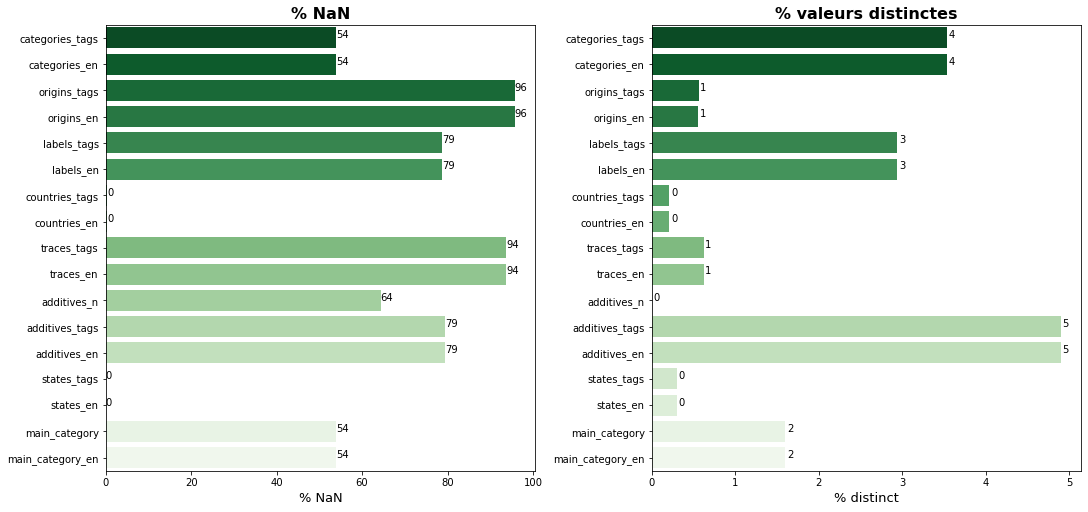

In [70]:
completion_distinct_plots(openfoodfacts.iloc[:,openfoodfacts.columns.isin(liste_col_en)])

Nous remarquons que les variables ayant le même préfixe comportent le même % de NaN et de valeurs distinctes. Comme nous avons déjà précedemment supprimé les variables sans suffixe, il nous reste les variables se terminant par _tags et _en. Nous avons donc le choix de conserver soit l'une soit l'autre. Vérifions juste un exemple avant de choisir quelles variables supprimer.

In [71]:
openfoodfacts[~openfoodfacts['categories_tags'].isnull()][['categories_tags', 'categories_en']].sample(10)

,categories_tags,categories_en
1829496,"en:groceries,en:condiments,en:salts,en:himalaya-salts","groceries,condiments,salts,himalaya salts"
464968,en:snacks,snacks
933164,"en:canned-foods,en:meals,en:meat-based-products,en:meals-with-meat,en:beef-dishes,en:beef-stews,en:canned-meals,en:boeufs-bourguignons","canned foods,meals,meat-based products,meals with meat,beef dishes,beef stews,canned meals,bœufs bourguignons"
69993,"en:dairies,en:fermented-foods,en:fermented-milk-products,en:cheeses","dairies,fermented foods,fermented milk products,cheeses"
486358,"en:meats,en:poultries","meats,poultries"
249566,"en:plant-based-foods-and-beverages,en:plant-based-foods,en:fruits-and-vegetables-based-foods","plant-based foods and beverages,plant-based foods,fruits and vegetables based foods"
19087,"en:beverages,en:carbonated-drinks,en:sodas","beverages,carbonated drinks,sodas"
1407903,nl:apero,nl:apero
772519,"en:meats,en:steaks","meats,steaks"
2013774,"en:boissons,en:sucre-fruits-points-vert","boissons,sucre-fruits-points-vert"


Les modalités étant plus lisibles et harmonisées dans les colonnes se terminant par _en, supprimons les colonnes _tags.

In [72]:
liste_col_suppr = openfoodfacts.iloc[:,(openfoodfacts.columns.isin(liste_col_en)) & 
                                        (openfoodfacts.columns.str.endswith('_tags'))].columns.unique().tolist()
print(f"Liste des variables à supprimer: \n\n {liste_col_suppr}")

Liste des variables à supprimer: 

 ['categories_tags', 'origins_tags', 'labels_tags', 'countries_tags', 'traces_tags', 'additives_tags', 'states_tags']


In [73]:
# Suppression des variables avec suffixe _tags
openfoodfacts = openfoodfacts.drop(liste_col_suppr, axis = 'columns', inplace = False)

print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 73


### url / image

Avant de supprimer ces variables, vérifions si elles contiennent des informations susceptibles de nous intéresser.

In [74]:
liste_col_url = openfoodfacts.iloc[:,openfoodfacts.columns.str.contains('url|image')].columns.unique().tolist()
openfoodfacts[liste_col_url].head()

,url,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url
0,http://world-en.openfoodfacts.org/product/00000000000000225/jeunes-pousses-endives,NaN,NaN,NaN,NaN,NaN,NaN
1,http://world-en.openfoodfacts.org/product/00000000000003429145/l-casei,https://images.openfoodfacts.org/images/products/000/000/000/00003429145/front_es.3.400.jpg,https://images.openfoodfacts.org/images/products/000/000/000/00003429145/front_es.3.200.jpg,https://images.openfoodfacts.org/images/products/000/000/000/00003429145/ingredients_es.6.400.jpg,https://images.openfoodfacts.org/images/products/000/000/000/00003429145/ingredients_es.6.200.jpg,https://images.openfoodfacts.org/images/products/000/000/000/00003429145/nutrition_es.7.400.jpg,https://images.openfoodfacts.org/images/products/000/000/000/00003429145/nutrition_es.7.200.jpg
2,http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers,https://images.openfoodfacts.org/images/products/000/000/000/0017/front_fr.4.400.jpg,https://images.openfoodfacts.org/images/products/000/000/000/0017/front_fr.4.200.jpg,https://images.openfoodfacts.org/images/products/000/000/000/0017/ingredients_fr.9.400.jpg,https://images.openfoodfacts.org/images/products/000/000/000/0017/ingredients_fr.9.200.jpg,NaN,NaN
3,http://world-en.openfoodfacts.org/product/0000000000031/cacao,https://images.openfoodfacts.org/images/products/000/000/000/0031/front_fr.3.400.jpg,https://images.openfoodfacts.org/images/products/000/000/000/0031/front_fr.3.200.jpg,NaN,NaN,NaN,NaN
4,http://world-en.openfoodfacts.org/product/000000000003327986/filetes-de-pollo-empanado,https://images.openfoodfacts.org/images/products/000/000/000/003327986/front_es.3.400.jpg,https://images.openfoodfacts.org/images/products/000/000/000/003327986/front_es.3.200.jpg,NaN,NaN,https://images.openfoodfacts.org/images/products/000/000/000/003327986/nutrition_es.5.400.jpg,https://images.openfoodfacts.org/images/products/000/000/000/003327986/nutrition_es.5.200.jpg


Nous remarquons que la variable 'url' contient le nom du produit. Nous la conservons donc pour éventuellement compléter les valeurs de la variable product_name qui pourraient ne pas être renseignées. Nous pouvons supprimer les autres variables.

In [75]:
liste_col_image = openfoodfacts.iloc[:,openfoodfacts.columns.str.contains('image')].columns.unique().tolist()
print(f"Liste des variables image à supprimer: \n\n {liste_col_image}")

Liste des variables image à supprimer: 

 ['image_url', 'image_small_url', 'image_ingredients_url', 'image_ingredients_small_url', 'image_nutrition_url', 'image_nutrition_small_url']


In [76]:
# Suppression des variables contenant les mot url ou image
openfoodfacts.drop(liste_col_image, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 67


## Autres variables <a class="anchor" id="misc"></a>

La nomenclature des variables nous donne d'autres informations. Elle se trouve à l'adresse: https://static.openfoodfacts.org/data/data-fields.txt

### Variables sur les ingredients

In [77]:
def check_redundancy(dataframe, keyword):
    ''' Fonction qui renseigne sur les principales statistiques des variables contenant le mot saisi en entrée.'''
    liste = dataframe.iloc[:,dataframe.columns.str.contains(keyword)].columns.unique().tolist()
    describe = describe_variables_light(dataframe[liste])
    return describe

In [78]:
def modalities_no_NaN(dataframe, keyword):
    ''' Fonction qui renvoie 5 exemples non nuls des variables contenant le mot saisi en entrée'''
    liste_col = check_redundancy(dataframe, keyword)['Variable name'].tolist()
    return dataframe[dataframe[liste_col].notnull().all(1)][liste_col].sample(5)

In [79]:
def check_redundancy_steps(dataframe, mot_clef):
    ''' Fonction qui renvoie 2 dataframes: 
    tab_desc qui renseigne sur les principales  statistiques des variables contenant le mot saisi en entrée
    tab_modalities qui renvoie 5 exemples non nuls des variables contenant le mot saisi en entrée'''
    tab_desc = check_redundancy(dataframe, mot_clef)
    tab_modalities = modalities_no_NaN(dataframe, mot_clef)
    return tab_desc, tab_modalities

In [80]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'ingredients')

In [81]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,ingredients_text,object,"leche semidesnatada, azucar 6.9% leche desnatada en polva, fermentos lacticos (contiene lactobacidus casei), vitaminas (b6 y d).",2053664,611037,29.75,732662,35.68,1321002,64.32
1,ingredients_from_palm_oil_n,float64,0.0,2053664,4,0.00,732664,35.68,1321000,64.32
2,ingredients_that_may_be_from_palm_oil_n,float64,0.0,2053664,7,0.00,732664,35.68,1321000,64.32
3,ingredients_that_may_be_from_palm_oil_tags,object,"e481-stearoyl-2-lactylate-de-sodium,e472e-ester-monoacethyltartrique-de-mono-et-diglycerides-d-acides-gras,e472b-ester-diacetyl-lactique-de-mono-et-diglycerides-d-acides-gras",2053664,350,0.02,43295,2.11,2010369,97.89
4,fruits-vegetables-nuts-estimate-from-ingredients_100g,float32,0.0,2053664,7644,0.37,731221,35.61,1322443,64.39


In [82]:
tab_modalities

,ingredients_text,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_tags,fruits-vegetables-nuts-estimate-from-ingredients_100g
839576,"portion de filets de _colin d‘alaska*_ 50% (theragra chalcogramma). pâte à beignet 35% : farine de _blé_, eau, huile végétale, amidon transformé de maïs, sel, farine de riz, amidon transforme de tapioca, _moutarde_ en poudre, agents levants : diphosphate disodique et carbonate acide de sodium, _lait_ écrémé en poudre, dextrose, levure, extrait de poivre noir, extrait de levure. émulsifiant : esters monoacétyltartrique et diacéthyltartriques des mono - et diglycérides d'acides gras, acide ascorbique. sauce 15% : tomate, vinaigre, sucre, amidon transformé, sel, épices et extrait d'herbes (dont _céleri_), ail en poudre. * malgré tout le soin apporté à lu préparation de nos produits la présence exceptionnelle d'arêtes n’est pas exclue.",0.0,1.0,huile-vegetale,0.0
828625,"sucre - farine de blé 19,5% - huile de colza - ceuts entiers 14,5% - sirop de qlucose - stabilisant: glycérol - purée d'abricot 5% - emulsifiant: mono - et diglycérides d'acides gras (origine végétale) - poudres à lever: carbonates de sodium, diphosphates - sel - arômes naturels - acidifiant: acide citrique gélifiant: pectines - concentré de carotte et potiron - correcteur d'acidité: citrates de calcium.",0.0,1.0,e471-mono-et-diglycerides-d-acides-gras-alimentaires,14.5
2044634,"creamer [ glucose syrup, hydrogenated palm kernel olls, sodium caseinate (contain milk protein), emulsifier e471, stabilizer e340, anti-caking agent e551, beta-carotene e160a ], sugar and instant black tea",0.0,2.0,"e471-mono-et-diglycerides-d-acides-gras-alimentaires,e160a-beta-carotene",0.0
1585668,"chocolat au lait 51 % [sucre, beurre de cacao, lait écrémé en poudre, pâte de cacao, lactosérum en poudre, beurre concentré, pâte de noisettes, émulsifiant (lécithine de soja), arôme], chocolat blanc 23 % [sucre, beurre de cacao, lait écrémé en poudre, lactosérum en poudre, beurre concentré, émulsifiants (lécithine de soja, e 476), arôme], noisettes, céréales croustillantes [farine de froment (60%), farine de riz, huile végétale, sucre, malt de blé, fibre de pois, poudre à lever (e 500), sel, arôme], beurre de cacao, agents d'enrobage (e 414, e 901), huile végétale. cacao : 30% minimum dans le chocolat au lait.",0.0,1.0,huile-vegetale,0.0
1003548,"lait écrémé reconstitué 60%, crème 16%, sucre, amidon modifié de maïs, chocolat 2,1% (sucre, pâte de cacao, beurre de cacao), cacao maigre en poudre, dextrose, gélatine bovine, lait écrémé concentré, émulsifiant : e471, lait écrémé en poudre, amidon de maïs, épaississant : carraghénanes, sel.",0.0,1.0,e471-mono-et-diglycerides-d-acides-gras-alimentaires,0.0


Nous pouvons remarquer que la variable ingredients_text contient un grand nombre de modalités et 64.32% de valeurs manquantes. Nous supprimons les variables ingredients_that_may_be_from_palm_oil_tags et ingredients_that_may_be_from_palm_oil_n afin de ne conserver que ingredients_from_palm_oil_n.

In [83]:
# Suppression des variables
openfoodfacts.drop(['ingredients_that_may_be_from_palm_oil_n', 
                    'ingredients_that_may_be_from_palm_oil_tags'], axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 65


### Variables de localisation <a class="anchor" id="localisation"></a>

#### places

In [84]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'places')

In [85]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,manufacturing_places_tags,object,benivay-ollon,2053664,25973,1.26,128360,6.25,1925304,93.75
1,purchase_places,object,france,2053664,10480,0.51,161427,7.86,1892237,92.14


In [86]:
tab_modalities

,manufacturing_places_tags,purchase_places
560477,"socopa-viandes-filiale-groupe-bigard-lieu-dit-les-bordes-d323-72400-cherre,sarthe,pays-de-la-loire,france","amiens,france"
1637698,mattarello-tn-italia,italia
880092,france,"france,nantes"
433884,mexico,walmart
955462,graulhet-81-france,france


Ces variables étant très peu alimentées (plus de 90% de NaN), supprimons les.

In [87]:
# Suppression des variables
openfoodfacts.drop(tab_modalities.columns, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 63


#### countries_en

In [88]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'countries_en')

In [89]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,countries_en,object,france,2053664,4403,0.21,2047473,99.7,6191,0.3


In [90]:
tab_modalities

,countries_en
2045223,france
1555405,germany
187538,canada
1149161,france
1909521,spain


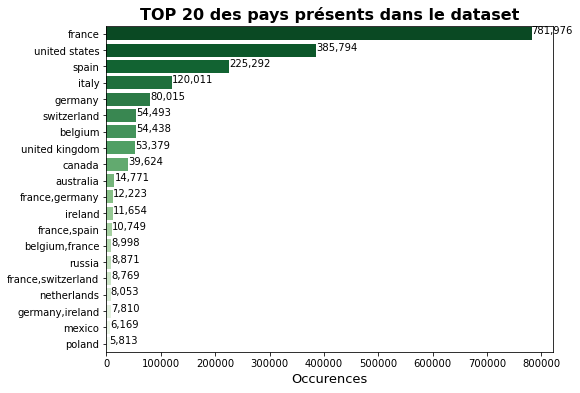

In [91]:
countries_en_count = openfoodfacts['countries_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
ax = sns.barplot(y = countries_en_count.index, x = countries_en_count.values, palette = 'Greens_r')
plt.title("TOP 20 des pays présents dans le dataset")
plt.ylabel("")
plt.xlabel("Occurences")
etiquette_h(ax);

On remarque que la France est en tête du classement suivie des Etats Unis et de l'Espagne. Cette variable ne contient que 0.3% de valeurs manquantes et 4 403 valeurs distinctes: la variable countries_en ne contient pas forcément un seul pays mais peut également contenir une liste de pays. On peut se poser la question de savoir si la France peut être traduite dans une autre langue:

In [92]:
openfoodfacts[openfoodfacts['countries_en'].str.contains(
    'france|fr', na = False)]['countries_en'].unique().tolist()[0:40]

['france',
 'france,united states',
 'belgium,france',
 'france,germany',
 'france,germany,netherlands',
 'france,switzerland',
 'france,united kingdom',
 'belgium,france,netherlands,united kingdom',
 'france,russia',
 'france,india',
 'austria,frankreich,spanien',
 'austria,france',
 'czech republic,france',
 'france,spain',
 'austria,france,germany',
 'australia,france',
 'france,switzerland,united states',
 'france,spain,united states',
 'france,thailand',
 'france,ireland',
 'france,gabon',
 'bulgaria,cyprus,france,germany,italy,poland',
 'french polynesia,united states',
 'canada,france',
 'france,réunion',
 'australia,belgium,france,germany,luxembourg,switzerland',
 'argentina,france,united states',
 'france,morocco',
 'france,germany,spain',
 'australia,france,new zealand',
 'french polynesia',
 'france,iraq',
 'czech republic,france,united states',
 'belgium,france,united states',
 'france,iraq,united states',
 'france,new caledonia',
 'australia,france,sweden,united states',
 

On remarque que les pays peuvent apparaitre dans plusieurs langues. Quelques exemples pour la France:
- France
- Frankreich
- French
- Francia
- Francja
- Frankrijk
- Franța
- Franca

On apprend sur le site https://www.economie.gouv.fr/dgccrf/Publications/Vie-pratique/Fiches-pratiques/Etiquetage-des-denrees-alimentaires que les étiquettes doivent être traduites au moins en français pour les produits vendus en France. Gardons cela en tête pour la suite du nettoyage.

### Variables sur le packaging <a class="anchor" id="packaging"></a>

Ces variables ne seront a priori pas utilisées par la suite, supprimons les mais regardons d'abord quelques exemples.

In [93]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'packaging')

In [94]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,packaging_tags,object,"barquette,plastique",2053664,46485,2.26,315888,15.38,1737776,84.62
1,first_packaging_code_geo,object,"47.833333,-0.333333",2053664,3768,0.18,73907,3.60,1979757,96.40


In [95]:
tab_modalities

,packaging_tags,first_packaging_code_geo
992715,"sachet,plastique","46.25,5.216667"
789704,frais,"46.9,-1.25"
893760,"plastique,pot","48.55,-1.516667"
797175,"frais,carton,sous-vide","48.1,-4"
950587,"brique,fr-brique-en-carton,brique-en-carton-et-bouchon-plastique","49.05,-1.033333"


Ces variables étant assez peu alimentées et non pertinentes pour notre idée d'application, supprimons les.

In [96]:
# Suppression des variables contenant le mot packaging
openfoodfacts.drop(tab_modalities.columns, axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 61


### Variables sur la marque <a class="anchor" id="brand"></a>

In [97]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'brand')

In [98]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,brands_tags,object,endives,2053664,141427,6.89,1050518,51.15,1003146,48.85
1,brand_owner,object,lagg's,2053664,25315,1.23,290020,14.12,1763644,85.88


In [99]:
tab_modalities

,brands_tags,brand_owner
3504,bill-knapp-s,"bake-a-teria, inc."
246121,procordia,ab felix
54021,"silk,wwf-operating-company",wwf operating company
1289638,"kaufland,k-take-it-veggie",kaufland
516400,coffee-house-cafe,hill country bakery l.l.c.


La variable brands_tags comporte bien moins de valeurs manquantes que brand_owner même si elle a plus de valeurs distinctes. Nous décidons de conserver brands_tags.

In [100]:
# Suppression de la variable brand_owner
openfoodfacts.drop('brand_owner', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 60


### Variables sur le nom des produits <a class="anchor" id="name"></a>

In [101]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'name')

In [102]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,product_name,object,jeunes pousses,2053664,1169500,56.95,1970349,95.94,83315,4.06
1,generic_name,object,blanquette de volaille et son riz,2053664,85950,4.19,123509,6.01,1930155,93.99


In [103]:
tab_modalities

,product_name,generic_name
1387823,free lemon 0.0%,μπύρα χωρίς αλκοόλ με χυμό λεμόνι
1170397,suppen gemüse mischung,suppengemüsemischung aus getrockneten gemüseflocken und kräutern
1020054,"colin d'alaska, crevettes et riz sauce crustacés","colin d'alaska fruits de mer et riz sauce crustacés, surgelé"
784000,cônes vanille fraise x6,"6 cônes de glace à la vanille (33,7%) et de glace à la fraise (33,7%) avec un crayon de sauce aux fruits rouges (5,7%), dans un cornet biscuit avec chemisage au cacao maigre (7,8%), et décor de sauce aux fruits rouges (2,8%), surgelés"
781187,pina colada 16%vol,"liqueur - rhum, ananas et arôme noix de coco"


Ces 2 variables nous apportent la même information. generic_name ayant un fort pourcentage de valeurs manquantes, nous décidons de la supprimer.

In [104]:
# Suppression de la variable generic_name
openfoodfacts.drop('generic_name', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 59


In [105]:
openfoodfacts[openfoodfacts['product_name'].isnull()][['url', 'product_name', 'brands_tags']].sample(10)

,url,product_name,brands_tags
1461308,http://world-en.openfoodfacts.org/product/5700383360535,NaN,NaN
2040318,http://world-en.openfoodfacts.org/product/9415077414826,NaN,NaN
1602461,http://world-en.openfoodfacts.org/product/7797330103114/grandiet,NaN,grandiet
603627,http://world-en.openfoodfacts.org/product/2186870004480,NaN,NaN
1320975,http://world-en.openfoodfacts.org/product/5000159408004/mars,NaN,mars
1915335,http://world-en.openfoodfacts.org/product/8437013383059,NaN,NaN
1316436,http://world-en.openfoodfacts.org/product/49111040/lipton,NaN,lipton
609768,http://world-en.openfoodfacts.org/product/2209579004312,NaN,NaN
1595154,http://world-en.openfoodfacts.org/product/7702011273468,NaN,NaN
1360587,http://world-en.openfoodfacts.org/product/5055256533401,NaN,NaN


Nous remarquons que la variable url est construite à partir d'autres variables comme le code, le nom du produit et sa marque. Nous aurions pu compléter les noms de produits manquants à l'aide de la variable url mais ces deux variables semblent liées ce qu'il signifie que lorsque le nom du produit est manquant, il n'est pas non plus renseigné dans la variable url.

In [106]:
# Suppression de la variable generic_name
openfoodfacts.drop('url', axis = 'columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 58


### Variables sur les additifs <a class="anchor" id="additives"></a>

In [107]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'additives')

In [108]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,additives_n,float64,0.0,2053664,40,0.0,732664,35.68,1321000,64.32
1,additives_en,object,"e296 - malic acid,e330 - citric acid,e552 - calcium silicate,e950 - acesulfame k,e955 - sucralose",2053664,100577,4.9,423380,20.62,1630284,79.38


In [109]:
tab_modalities

,additives_n,additives_en
1179897,4.0,"e160a - carotene,e331 - sodium citrates,e450 - diphosphates,e452 - polyphosphates"
559525,7.0,"e200 - sorbic acid,e202 - potassium sorbate,e401 - sodium alginate,e407 - carrageenan,e415 - xanthan gum,e450 - diphosphates,e452 - polyphosphates"
191695,10.0,"e102 - tartrazine,e110 - sunset yellow fcf,e270 - lactic acid,e319 - tertiary-butylhydroquinone (tbhq),e330 - citric acid,e339ii - disodium phosphate,e340 - potassium phosphates,e340ii - dipotassium phosphate,e412 - guar gum,e554 - sodium aluminium silicate,e621 - monosodium glutamate"
520501,15.0,"e102 - tartrazine,e129 - allura red ac,e133 - brilliant blue fcf,e150 - caramel,e160a - carotene,e160ai - beta-carotene,e211 - sodium benzoate,e322 - lecithins,e322i - lecithin,e330 - citric acid,e331 - sodium citrates,e339ii - disodium phosphate,e415 - xanthan gum,e428 - gelatine,e435 - polyoxyethylene sorbitan monostearate,e475 - polyglycerol esters of fatty acids,e481 - sodium stearoyl-2-lactylate"
1821786,4.0,"e160 - carotenoids,e202 - potassium sorbate,e330 - citric acid,e476 - polyglycerol polyricinoleate"


Le pourcentage de valeurs manquantes étant "acceptable", nous décidons de conserver ces variables pour le moment.

### Variables sur les dates <a class="anchor" id="dates"></a>

Nous avons vu que toutes les variables de dates ne contiennent pas de valeurs manquantes. Nous allons conserver uniquement la date de modification.

In [110]:
openfoodfacts['last_modified_t'] = pd.to_datetime(openfoodfacts['last_modified_t'], unit='s')
openfoodfacts.rename(columns={'last_modified_t': 'last_modified_date'}, inplace = True)

In [111]:
# Suppression des autres variables de date
openfoodfacts.drop(['created_t', 'created_datetime', 'last_modified_datetime'], 
                   axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 55


### Variables sur les portions <a class="anchor" id="serving"></a>

Les variables qui commencent par serving_ correspondent au nombre de nutriments (en g, ou kj pour l'énergie) pour une part du produit. Elles doivent être de type numérique.

In [112]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'serving')

In [113]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,serving_size,object,serving,2053664,45410,2.21,509791,24.82,1543873,75.18
1,serving_quantity,float64,28.0,2053664,2456,0.12,505557,24.62,1548107,75.38


In [114]:
tab_modalities

,serving_size,serving_quantity
216521,0.25 pizza (132 g),132.0
1169357,45 g,45.0
1211581,100g,100.0
132930,1/2 cup (113 g),113.0
55359,1 cup (11 g),11.0


Ces 2 colonnes semblent être redondantes. Le % de NaN étant assez similaire et la variable serving_quantity déjà au format numérique, supprimons la variable serving_size.

In [115]:
# Suppression de la variable serving_size
openfoodfacts.drop('serving_size', axis = 'columns', inplace = True)

print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 54


### Variables sur les labels <a class="anchor" id="labels"></a>

In [116]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'labels')

In [117]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,labels_en,object,fr:delois-france,2053664,60361,2.94,438455,21.35,1615209,78.65


In [118]:
tab_modalities

,labels_en
491665,no colorings
1702475,"organic,eu organic,it-bio-014"
1095894,"organic,eu organic,ab agriculture biologique"
762133,no additives
1177187,"organic,eu organic,de-öko-006"


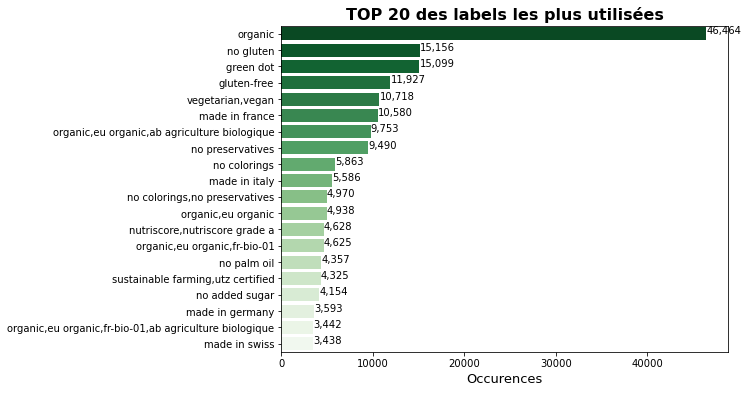

In [119]:
labels_en_count = openfoodfacts['labels_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
ax = sns.barplot(y = labels_en_count.index, x = labels_en_count.values, palette = 'Greens_r')
plt.title("TOP 20 des labels les plus utilisées")
plt.ylabel("")
plt.xlabel("Occurences")
etiquette_h(ax);

Gardons cette variable qui permet notamment de savoir si le produit provient de l'agriculture biologique par exemple.

### Variables sur les scores <a class="anchor" id="scores"></a>

#### Nutriscore

Le nutriscore est attribué sur la base d’un score prenant en compte pour 100 gr ou 100 mL de produit, la teneur :

- en nutriments et aliments à favoriser (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive),
- et en nutriments à limiter (énergie, acides gras saturés, sucres, sel)

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.

In [120]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'score')

In [121]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,nutriscore_score,float64,18.0,2053664,56,0.0,730953,35.59,1322711,64.41
1,nutriscore_grade,object,d,2053664,5,0.0,730953,35.59,1322711,64.41
2,nutrition-score-fr_100g,float32,18.0,2053664,56,0.0,730957,35.59,1322707,64.41


In [122]:
tab_modalities

,nutriscore_score,nutriscore_grade,nutrition-score-fr_100g
1142971,12.0,d,12.0
99115,18.0,e,18.0
939521,15.0,d,15.0
260313,-3.0,a,-3.0
1941913,-5.0,a,-5.0


Les variables nutriscore_score et nutrition-score-fr_100g apportent la même information et contiennent le même pourcentage de valeurs manquantes. Nous ne conserverons qu'une de ces deux variables.

In [123]:
# Suppression de la variable nutriscore_score
openfoodfacts.drop('nutriscore_score', axis='columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 53


In [124]:
openfoodfacts['nutriscore_grade'].value_counts(ascending = True)

b     95318
a    116663
e    134649
c    157241
d    227082
Name: nutriscore_grade, dtype: int64

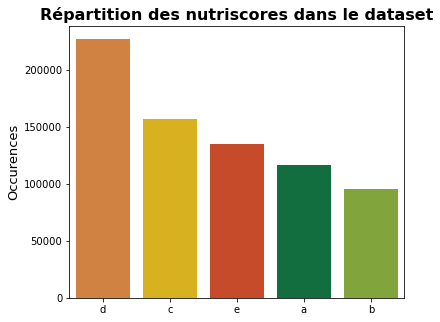

In [125]:
nutriscore_count = openfoodfacts['nutriscore_grade'].value_counts()

plt.figure(figsize=(6, 5))
sns.barplot(x = nutriscore_count.index, y = nutriscore_count.values, palette = ['#e78029', '#f5c301', '#df3c10', '#037d3f', '#88b52c'])
plt.title("Répartition des nutriscores dans le dataset")
plt.ylabel("Occurences")
plt.xlabel("");

Les produits moyennement et mal notés sont le plus représentés.

#### Groupe Nova

Les groupes Nova correspondent à une classification en 4 groupes selon le degré de transformation des aliments.
- Groupe 1 - Aliments non transformés ou transformés minimalement
- Groupe 2 - Ingrédients culinaires transformés
- Groupe 3 - Aliments transformés
- Groupe 4 - Produits alimentaires et boissons ultra-transformés

De nouvelles recherches de chercheurs de l'Inserm, de l'Inra et de l'Université Paris 13 (EREN) suggèrent une corrélation entre la consommation d'aliments ultra-transformés et un risque accru de développer un cancer.

In [126]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'nova_group')

In [127]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,nova_group,float64,4.0,2053664,4,0.0,640088,31.17,1413576,68.83


In [128]:
# Transformons cette variable en int
col = np.array(openfoodfacts['nova_group'], np.int8) # conversion en numpy array

openfoodfacts['nova_group'] = col # remplacement de nova group par le numpy array

In [129]:
# On remplace les 0 par NaN
openfoodfacts.loc[openfoodfacts['nova_group'] == 0, 'nova_group'] = np.nan

In [130]:
# On rajoute Group devant le numéro
openfoodfacts['nova_group'] = [f'Group {i}' for i in openfoodfacts['nova_group']]

In [131]:
# On enlève le .0 qui apparait après le nombre
openfoodfacts['nova_group'] = [str(i).replace('.0', '') for i in openfoodfacts['nova_group']]

In [132]:
# On transforme Group nan en np.nan
openfoodfacts.loc[openfoodfacts['nova_group'] == 'Group nan', 'nova_group'] = np.nan

In [133]:
# Fréquence de nova group dans le dataset
nova_percent = openfoodfacts[openfoodfacts['nova_group'] != 'nan'][
    'nova_group'].value_counts(normalize=True) * 100

In [134]:
data = nova_percent.values
labels = nova_percent.index

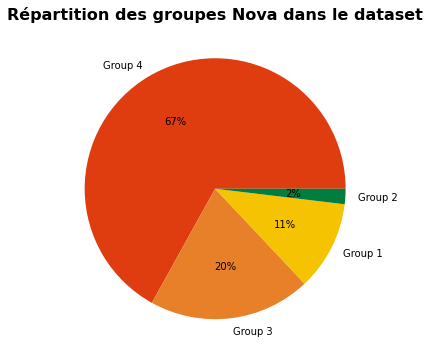

In [135]:
plt.figure(figsize=(8, 6))
plt.title("Répartition des groupes Nova dans le dataset")
plt.pie(data, labels = labels, colors = ['#df3c10', '#e78029', '#f5c301',  '#037d3f'], autopct='%.0f%%');

De la même manière que le nutriscore, les produits les plus transformés sont les plus représentés dans le dataset.

### Variables sur les catégories de produits <a class="anchor" id="categ"></a>

#### Categories

In [136]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'categ')

In [137]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,categories_en,object,"groceries,condiments,sauces,mustards",2053664,72799,3.54,945130,46.02,1108534,53.98
1,main_category,object,en:mustards,2053664,32887,1.60,945130,46.02,1108534,53.98
2,main_category_en,object,mustards,2053664,32885,1.60,945130,46.02,1108534,53.98


In [138]:
tab_modalities

,categories_en,main_category,main_category_en
463212,"plant-based foods and beverages,beverages,plant-based beverages",en:plant-based-beverages,plant-based beverages
685148,"dairies,fermented foods,fermented milk products,cheeses,cooked pressed cheeses,cow cheeses,emmentaler,cheeses of the netherlands,pasteurized cheeses,sliced cheeses",en:sliced-cheeses,sliced cheeses
147293,"dairies,fermented foods,fermented milk products,cheeses",en:cheeses,cheeses
1335852,"beverages,alcoholic beverages,wines,fortified wines,ports",en:ports,ports
1797980,"plant-based foods and beverages,plant-based foods,cereals and potatoes,breads,breadsticks,es:picos de pan",es:picos-de-pan,es:picos de pan


Ces 3 variables nous apportent la même information avec plus ou moins de détail. On note que les variables main_category sont égales au dernier élément de la liste categories_en. Le pourcentage de valeurs manquantes étant le même, notre critère de sélection sera porté sur le pourcentage de valeurs distinctes. Parmi les 2 variables avec le taux de valeurs distinctes le plus bas, nous décidons de conserver main_category_en.

In [139]:
# Suppression des variables categories_en et main_category
openfoodfacts.drop(['categories_en', 'main_category'], axis='columns', inplace = True)
print(f"Nombre de lignes: {openfoodfacts.shape[0]}\nNombre de variables: {openfoodfacts.shape[1]}")

Nombre de lignes: 2053664
Nombre de variables: 51


Regardons plus en détail les différentes modalités de la variable categories_en.

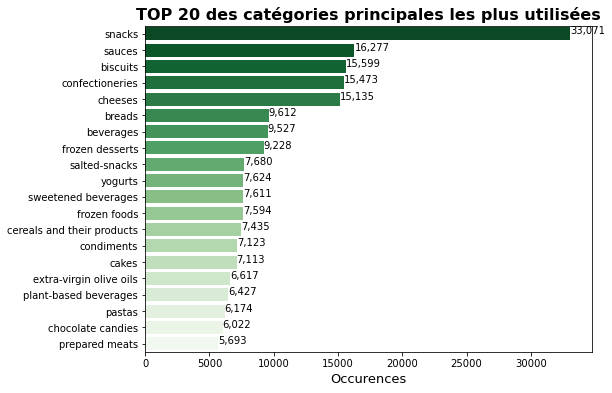

In [140]:
main_category_en_count = openfoodfacts['main_category_en'].value_counts()[0:20]

plt.figure(figsize=(8, 6))
ax = sns.barplot(y = main_category_en_count.index, x = main_category_en_count.values, palette = 'Greens_r')
plt.title("TOP 20 des catégories principales les plus utilisées")
plt.ylabel("")
plt.xlabel("Occurences")
etiquette_h(ax);

Cette variable pourrait être utilisée pour permettre de proposer un produit équivalent, mieux noté. Nous allons essayer de compléter le mapping de cette variable à l'aide des product_names. Pour le moment cette variable est complétée à presque 54%.

In [141]:
def mapping(dataframe, var_to_map, var_mapping):
    table_mapping = dataframe.groupby([var_mapping, var_to_map, 'last_modified_date'])['code'].count().reset_index()
    table_mapping = table_mapping.sort_values('last_modified_date', ascending = True)
    table_mapping = table_mapping.drop_duplicates(subset = var_mapping, keep = 'last')
    
    # Merge du dataframe avec la table de mapping
    df = pd.merge(left = dataframe, right = table_mapping[[var_mapping, var_to_map]], 
                  how = "left", on = var_mapping)
    
    # Lorsque la var_to_map est NaN, je complète avec la valeur du mapping
    df[f'{var_to_map}_x'] = np.where(df[f'{var_to_map}_x'].isnull(), 
                                     df[f'{var_to_map}_y'], 
                                     df[f'{var_to_map}_x'])
    
    # On supprime la variable issue de la jointure et on enlève le suffixe _x
    df.rename(columns={f'{var_to_map}_x': var_to_map}, inplace = True)
    df.drop(f'{var_to_map}_y', axis = 'columns', inplace = True)
    
    return df

In [142]:
# Mapping de main_category_en à l'aide du product_name
openfoodfacts = mapping(openfoodfacts, 'main_category_en', 'product_name')

In [143]:
# Taux de remplissage
round(openfoodfacts['main_category_en'].notna().mean(),4)*100

62.77

Grâce au mapping à l'aide des product_names, le taux de remplissage de la variable main_category_en est passé de 54% à près de 63%.

#### Groupes pnns

Le Programme national nutrition santé a été créé en 2001, et son site grand public a été lancé à la rentrée 2004, par l'Agence française de sécurité sanitaire des aliments et poursuivi par l'Agence nationale de santé publique. 

Ce programme a pour objectif général l’amélioration de l’état de santé de l’ensemble de la population en agissant sur l’un de ses déterminants majeurs : la nutrition. Ce programme agit à plusieurs niveaux: industrie, consommateurs, recherche afin d'atteindre ses objectifs (par exemple : diminution de la consommation de sel).

In [144]:
tab_desc, tab_modalities = check_redundancy_steps(openfoodfacts, 'pnns')

In [145]:
tab_desc

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN
0,pnns_groups_1,object,unknown,2053664,12,0.0,2053538,99.99,126,0.01
1,pnns_groups_2,object,unknown,2053664,41,0.0,2053539,99.99,125,0.01


Les variables pnns_groups n'ont que 0.01 % de NaN, mais il semble y avoir la mention "unknown" qui correspond en réalité à une valeur non renseignée. Regardons les différentes modalités de ces variables.

In [146]:
tab_modalities

,pnns_groups_1,pnns_groups_2
595858,fish meat eggs,processed meat
1994578,unknown,unknown
477212,fat and sauces,dressings and sauces
918906,unknown,unknown
1406901,unknown,unknown


In [147]:
# Vérification des mentions unknown
openfoodfacts[openfoodfacts[['pnns_groups_1', 'pnns_groups_2']]== "unknown"][
    ['pnns_groups_1', 'pnns_groups_2']]

,pnns_groups_1,pnns_groups_2
0,unknown,unknown
1,unknown,unknown
2,unknown,unknown
3,unknown,unknown
4,unknown,unknown
...,...,...
2053659,unknown,unknown
2053660,unknown,unknown
2053661,unknown,unknown
2053662,unknown,unknown


Il semblerait que quand l'un des groupes pnns soit unknown, l'autre le soit aussi. Regardons si l'on peut obtenir plus d'information en rajoutant la colonne main_category_en.

In [148]:
openfoodfacts[openfoodfacts[['pnns_groups_1', 'pnns_groups_2', 'main_category_en']].notnull().all(1)][
    ['pnns_groups_1', 'pnns_groups_2', 'main_category_en']]

,pnns_groups_1,pnns_groups_2,main_category_en
0,unknown,unknown,fr:melanges-de-salades
1,unknown,unknown,drinkable yogurts
3,unknown,unknown,cocoa powders
7,fat and sauces,dressings and sauces,mustards
11,unknown,unknown,special breads
...,...,...,...
2053654,unknown,unknown,ar:13
2053655,sugary snacks,biscuits and cakes,de:tiefkühl-kuchen
2053656,fish meat eggs,meat,ground beef steaks
2053657,sugary snacks,sweets,marrons glacés


**pnns_groups_1**

In [149]:
# Modalités de pnns_groups_1
openfoodfacts['pnns_groups_1'].unique()

array(['unknown', 'fat and sauces', 'composite foods', 'sugary snacks',
       'fruits and vegetables', 'fish meat eggs', 'beverages',
       'milk and dairy products', 'cereals and potatoes', 'salty snacks',
       'alcoholic beverages', nan, 'sugary-snacks'], dtype=object)

In [150]:
# On renomme les pnns groups 1 identiques
openfoodfacts.loc[openfoodfacts['pnns_groups_1'] == 'sugary-snacks', 'pnns_groups_1'] = 'sugary snacks'

In [151]:
# On affecte les "unknown" en NaN
openfoodfacts.loc[openfoodfacts['pnns_groups_1']== 'unknown', 'pnns_groups_1'] = np.nan

In [152]:
# Taux de remplissage
round(openfoodfacts['pnns_groups_1'].notna().mean(),4)*100

37.519999999999996

In [153]:
# Amélioration du mapping des pnns_groups_1 à l'aide des product_name
openfoodfacts = mapping(openfoodfacts, 'pnns_groups_1', 'product_name')

In [154]:
# Taux de remplissage
round(openfoodfacts['pnns_groups_1'].notna().mean(),4)*100

54.43

In [155]:
# Amélioration du mapping des pnns_groups_1 à l'aide des main_category_en
openfoodfacts = mapping(openfoodfacts, 'pnns_groups_1', 'main_category_en')

In [156]:
# Taux de remplissage
round(openfoodfacts['pnns_groups_1'].notna().mean(),4)*100

61.870000000000005

In [157]:
# Amélioration du mapping des pnns_groups_1 à l'aide des pnns_groups_2
openfoodfacts = mapping(openfoodfacts, 'pnns_groups_1', 'pnns_groups_2')

In [158]:
# Taux de remplissage
round(openfoodfacts['pnns_groups_1'].notna().mean(),4)*100

99.99

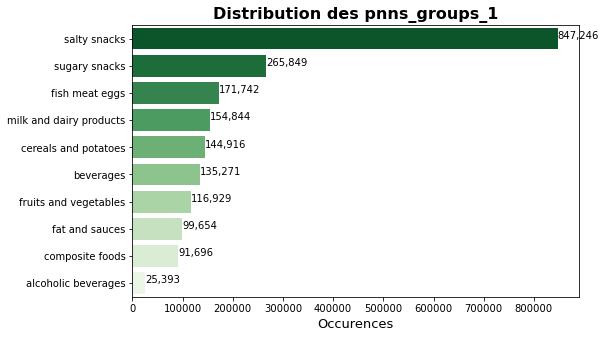

In [159]:
pnns1_count = openfoodfacts['pnns_groups_1'].value_counts()

plt.figure(figsize=(8, 5))
ax = sns.barplot(y = pnns1_count.index, x = pnns1_count.values, palette = 'Greens_r')
plt.title("Distribution des pnns_groups_1")
plt.ylabel("")
plt.xlabel("Occurences")
etiquette_h(ax);

**pnns_groups_2**

In [160]:
# Modalités de pnns_groups_2
openfoodfacts['pnns_groups_2'].unique()

array(['unknown', 'dressings and sauces', 'one-dish meals',
       'biscuits and cakes', 'fruits', 'meat', 'sweets',
       'sweetened beverages', 'cheese', 'bread', 'fish and seafood',
       'salty and fatty products', 'fruit juices', 'dried fruits',
       'vegetables', 'fats', 'dairy desserts', 'milk and yogurt',
       'pastries', 'pizza pies and quiches', 'legumes',
       'unsweetened beverages', 'nuts', 'cereals', 'alcoholic beverages',
       'breakfast cereals', 'appetizers', 'processed meat',
       'chocolate products', 'eggs', 'plant-based milk substitutes',
       'sandwiches', 'ice cream', 'soups',
       'teas and herbal teas and coffees', 'potatoes',
       'artificially sweetened beverages', 'waters and flavored waters',
       'offals', nan, 'fruit nectars', 'pizza pies and quiche'],
      dtype=object)

In [161]:
# On renomme les pnns groups 2 identiques
openfoodfacts.loc[openfoodfacts['pnns_groups_2'] == 'pizza pies and quiche', 'pnns_groups_2'] = 'pizza pies and quiches'

In [162]:
# On affecte les "unknown" en NaN
openfoodfacts.loc[openfoodfacts['pnns_groups_2'] == 'unknown', 'pnns_groups_2'] = np.nan

In [163]:
# Taux de remplissage
round(openfoodfacts['pnns_groups_2'].notna().mean(),4)*100

37.519999999999996

In [164]:
# Amélioration du mapping des pnns_groups_2 à l'aide des product_name
openfoodfacts = mapping(openfoodfacts, 'pnns_groups_2', 'product_name')

In [165]:
# Taux de remplissage
round(openfoodfacts['pnns_groups_2'].notna().mean(),4)*100

54.43

In [166]:
# Amélioration du mapping des pnns_groups_2 à l'aide des main_category_en
openfoodfacts = mapping(openfoodfacts, 'pnns_groups_2', 'main_category_en')

In [167]:
# Taux de remplissage
round(openfoodfacts['pnns_groups_2'].notna().mean(),4)*100

61.870000000000005

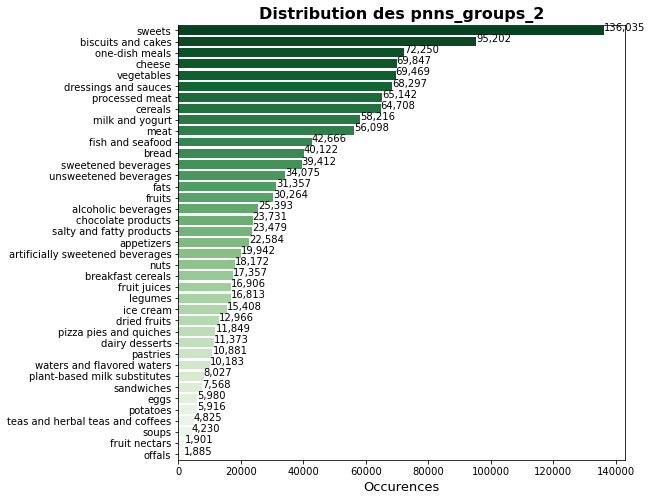

In [168]:
pnns2_count = openfoodfacts['pnns_groups_2'].value_counts()

plt.figure(figsize=(8, 8))
ax = sns.barplot(y = pnns2_count.index, x = pnns2_count.values, palette = 'Greens_r')
plt.title("Distribution des pnns_groups_2")
plt.ylabel("")
plt.xlabel("Occurences")
etiquette_h(ax);

Cette meilleure connaissance des variables présentes dans le dataset nous a permis de commencer à supprimer des variables redondantes, comprendre leur construction et avoir des idées de stratégies pour imputer les valeurs manquantes. Certaines variables ne seront pas utilisées, supprimons les:

In [169]:
openfoodfacts.columns

Index(['code', 'creator', 'last_modified_date', 'product_name', 'quantity',
       'brands_tags', 'origins_en', 'labels_en', 'emb_codes_tags',
       'cities_tags', 'stores', 'countries_en', 'ingredients_text',
       'allergens', 'traces_en', 'serving_quantity', 'additives_n',
       'additives_en', 'ingredients_from_palm_oil_n', 'nutriscore_grade',
       'nova_group', 'pnns_groups_1', 'pnns_groups_2', 'states_en',
       'main_category_en', 'energy-kj_100g', 'energy-kcal_100g', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g',
       'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
       'vitamin-pp_100g', 'potassium_100g', 'calcium_100g', 'iron_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutri

In [170]:
openfoodfacts_light = openfoodfacts.drop(['creator', 'last_modified_date', 'quantity', 'origins_en', 'emb_codes_tags', 
                                    'cities_tags', 'stores', 'traces_en','serving_quantity', 'states_en'], 
                                   axis = 'columns', inplace = False)

In [171]:
shape_total_nan(openfoodfacts_light)

Nombre de lignes: 2053664
Nombre de colonnes: 41
Nombre total de NaN du dataset: 49632153
% total de NaN du dataset: 58.95%


Dataset après passage en revue des différents groupes de variables:
- Nombre de lignes: 2 053 664
- Nombre de variables: **41**
- **58.95%** de valeurs manquantes dans le dataset

## Valeurs aberrantes <a class="anchor" id="outliers"></a>

In [172]:
# Copie du dataset
openfoodfacts_outliers = openfoodfacts_light.copy()

Les valeurs aberrantes des variables quantitatives doivent être vérifiées et traitées en conséquence afin de ne pas ajouter de biais lorsque nous imputerons les valeurs manquantes. 

J'ai identifié 4 manières de repérer ces outliers:

- aucune variable hors energy ne peut être supérieure à 100 ou inférieure à 0
- une sous catégorie de variable ne peut pas être supérieure à la variable "parent"
- la somme des variables de nutriments doit être inférieure ou égale à 100 (hors energy et variables secondaires qui rentrent dans la composition d'une autre variable)
- un aliment ne peut être plus calorique qu'un certain seuil: 900 calories maximum ce qui équivaut à 100% de lipides (= fat): huile d'olive par exemple. Pour avoir la correspondance en kilojoules, il faut multiplier par 4.184 soit un seuil maximum de 3 766 kJ. L'énergie en kcal pour 100 grammmes d'aliment peut être recalculée par la formule suivante: 9 * lipides + 7 * alcool + 4 * protéines + 4 * glucides.

### Valeurs supérieures à 100 et inférieures à 0

In [173]:
openfoodfacts_outliers.columns[openfoodfacts_outliers.columns.str.contains('_100g')]

Index(['energy-kj_100g', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'sodium_100g', 'alcohol_100g', 'vitamin-a_100g',
       'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g',
       'vitamin-pp_100g', 'potassium_100g', 'calcium_100g', 'iron_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

In [174]:
# Filtre sur les variables hors energy
liste_col_nutriments = openfoodfacts_outliers.columns[(openfoodfacts_outliers.columns.str.contains('_100g')) & 
                               (~openfoodfacts_outliers.columns.str.contains(
                                   'energy'))]

In [175]:
shape_total_nan(openfoodfacts_outliers)

Nombre de lignes: 2053664
Nombre de colonnes: 41
Nombre total de NaN du dataset: 49632153
% total de NaN du dataset: 58.95%


In [176]:
# Affectation des outliers en np.nan
for col in liste_col_nutriments:
    openfoodfacts_outliers.loc[openfoodfacts_outliers[col] > 100, col] = np.nan
    openfoodfacts_outliers.loc[openfoodfacts_outliers[col] < 0, col] = np.nan

In [177]:
shape_total_nan(openfoodfacts_outliers)

Nombre de lignes: 2053664
Nombre de colonnes: 41
Nombre total de NaN du dataset: 49751545
% total de NaN du dataset: 59.09%


### Valeurs des variables qui rentrent dans la composition d'une autre variable

Certaines variables comme saturated-fat_100g, monounsaturated-fat_100g etc rentrent dans la composition de la variable fat_100g. La somme de ces variables ne peut excéder la valeur de la variable principale. Nous allons créer des listes pour chaque variable parent composées des variables qui rentrent dans sa composition, vérifierons si leur somme est supérieure à celle de la variable parent et, si c'est le cas, supprimerons ces observations.

In [178]:
liste_col_fat = ['saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'trans-fat_100g', 'cholesterol_100g']
liste_col_carbo = ['sugars_100g', 'fiber_100g']
liste_col_salt = ['sodium_100g']

#### Fat

In [179]:
openfoodfacts_outliers[openfoodfacts_outliers['fat_100g'] < (
    openfoodfacts_outliers[liste_col_fat].sum(axis = 'columns'))][['fat_100g', 'saturated-fat_100g', 
                                                                 'monounsaturated-fat_100g', 
                                                                 'polyunsaturated-fat_100g', 
                                                                 'trans-fat_100g', 'cholesterol_100g']]

,fat_100g,saturated-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,trans-fat_100g,cholesterol_100g
60,28.57,28.570000,NaN,NaN,0.000,0.01800
290,28.57,28.570000,NaN,NaN,0.000,0.01800
391,10.70,2.000000,3.33,5.33,0.667,0.00533
1385,0.00,0.000000,NaN,NaN,0.000,0.12400
1458,0.00,0.000000,NaN,NaN,0.000,0.81900
...,...,...,...,...,...,...
2044681,27.50,12.600000,12.00,3.00,0.000,0.00000
2045213,21.60,32.700001,NaN,NaN,NaN,NaN
2045751,1.00,1.100000,NaN,NaN,NaN,NaN
2046782,35.00,56.000000,NaN,NaN,NaN,NaN


In [180]:
# Observations où la somme des composants dépasse fat_100g
fat_sup = openfoodfacts_outliers['fat_100g'] < (openfoodfacts_outliers[liste_col_fat].sum(axis='columns'))
print("Nombre de lignes où la somme des composants de 'fat_100g' est supérieure à 'fat_100g': ", 
      openfoodfacts_outliers[fat_sup].shape[0])

Nombre de lignes où la somme des composants de 'fat_100g' est supérieure à 'fat_100g':  12064


In [181]:
# On affecte np.nan à tous les composants quand leur somme excède la variable principale
#openfoodfacts_outliers.loc[:,liste_col_fat] = openfoodfacts_outliers[liste_col_fat].where(~ fat_sup, 
#                                                                                          other = np.nan)

In [182]:
# On supprime les lignes
openfoodfacts_outliers = openfoodfacts_outliers[~fat_sup]

In [183]:
shape_total_nan(openfoodfacts_outliers)

Nombre de lignes: 2041600
Nombre de colonnes: 41
Nombre total de NaN du dataset: 49613263
% total de NaN du dataset: 59.27%


#### Carbohydrates

In [184]:
openfoodfacts_outliers[openfoodfacts_outliers['carbohydrates_100g'] < (
    openfoodfacts_outliers[liste_col_carbo].sum(axis = 'columns'))][['carbohydrates_100g', 
                                                                   'sugars_100g', 
                                                                   'fiber_100g']]

,carbohydrates_100g,sugars_100g,fiber_100g
132,15.15,NaN,15.2
219,13.89,NaN,13.9
223,21.43,3.570000,17.9
231,20.00,16.299999,10.0
268,1.80,1.600000,16.0
...,...,...,...
2048013,3.90,1.600000,3.9
2048054,0.50,0.500000,0.2
2048164,9.90,9.300000,1.2
2048228,2.00,0.500000,25.0


In [185]:
# Observations où la somme des composants dépasse carbohydrates_100g
carbo_sup = openfoodfacts_outliers['carbohydrates_100g'] < (openfoodfacts_outliers[liste_col_carbo].sum(axis='columns'))
print("Nombre de lignes où la somme des composants de 'carbohydrates_100g' est supérieure à 'carbohydrates_100g': ", 
      openfoodfacts_outliers[carbo_sup].shape[0])

Nombre de lignes où la somme des composants de 'carbohydrates_100g' est supérieure à 'carbohydrates_100g':  58811


In [186]:
# On supprime les lignes
openfoodfacts_outliers = openfoodfacts_outliers[~carbo_sup]

In [187]:
shape_total_nan(openfoodfacts_outliers)

Nombre de lignes: 1982789
Nombre de colonnes: 41
Nombre total de NaN du dataset: 48579571
% total de NaN du dataset: 59.76%


#### Salt

In [188]:
openfoodfacts_outliers[openfoodfacts_outliers['salt_100g'] < (
    openfoodfacts_outliers[liste_col_salt].sum(axis = 'columns'))][['salt_100g','sodium_100g']]

,salt_100g,sodium_100g
24118,0.000000,0.004000
683390,0.000180,0.072000
729650,0.124968,49.987202
768588,0.000590,0.236000
771260,0.002413,0.380000
794476,0.000180,0.072000
1045701,0.436880,3.320000
1319134,0.000000,0.080000
1359145,0.000000,0.040000
1520990,0.013000,0.124800


In [189]:
# Observations où la valeur du sodium dépasse celle du sel
salt_sup = openfoodfacts_outliers['salt_100g'] < (openfoodfacts_outliers[liste_col_salt].sum(axis='columns'))
print("Nombre de lignes où sodium_100g est supérieur à 'salt_100g': ", 
      openfoodfacts_outliers[salt_sup].shape[0])

Nombre de lignes où sodium_100g est supérieur à 'salt_100g':  14


In [190]:
# On affecte np.nan à tous les composants quand leur somme excède la variable principale
openfoodfacts_outliers.loc[:,liste_col_salt] = openfoodfacts_outliers[liste_col_salt].where(~ salt_sup, 
                                                                                          other = np.nan)

In [191]:
# Taux de remplissage
round(openfoodfacts[['sodium_100g', 'salt_100g']].notna().mean(),4)*100

sodium_100g    74.15
salt_100g      74.15
dtype: float64

La documentation nous indique que la variable sodium correspond à la variable salt_100g divisé par un coefficient de conversion de 2.5. Le taux de remplissage étant le même pour ces 2 variables, nous allons remplacer les valeurs de la variable sodium_100g en suivant cette formule.

In [192]:
openfoodfacts_outliers.loc[salt_sup,'sodium_100g'] = openfoodfacts_outliers['salt_100g']/2.5

In [193]:
shape_total_nan(openfoodfacts_outliers)

Nombre de lignes: 1982789
Nombre de colonnes: 41
Nombre total de NaN du dataset: 48579571
% total de NaN du dataset: 59.76%


### Somme des nutriments supérieures à 100

In [194]:
liste_col_nutriments = ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'alcohol_100g', 
                        'vitamin-a_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 
                        'vitamin-pp_100g', 'potassium_100g', 'calcium_100g', 'iron_100g']

In [195]:
openfoodfacts_outliers[openfoodfacts_outliers[liste_col_nutriments].sum(axis = 'columns') > 100][liste_col_nutriments]

,fat_100g,carbohydrates_100g,proteins_100g,salt_100g,alcohol_100g,vitamin-a_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,potassium_100g,calcium_100g,iron_100g
131,42.860001,38.099998,19.049999,0.09652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.286,0.01286
209,3.230000,96.769997,12.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00232
225,28.000000,60.000000,12.000000,0.20320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160,0.00288
230,56.669998,20.000000,26.670000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300,0.00540
271,7.500000,75.000000,17.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050,0.00450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052634,38.000000,40.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2052641,36.000000,60.000000,27.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2052643,35.000000,48.000000,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2052644,35.000000,48.000000,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [196]:
# Observations où la somme des nutriments dépasse 100g
sum_nutriments = openfoodfacts_outliers[liste_col_nutriments].sum(axis='columns') > 100
print("Nombre de lignes où la somme des nutriments dépasse 100g: ", openfoodfacts_outliers[sum_nutriments].shape[0])

Nombre de lignes où la somme des nutriments dépasse 100g:  16669


In [197]:
# On supprime les lignes
openfoodfacts_outliers = openfoodfacts_outliers[~sum_nutriments]

In [198]:
shape_total_nan(openfoodfacts_outliers)

Nombre de lignes: 1966120
Nombre de colonnes: 41
Nombre total de NaN du dataset: 48252840
% total de NaN du dataset: 59.86%


### Calories supérieures à 900 ou kilojoules supérieurs à 3 766

La valeur énergétique d'un aliment est la quantité d'énergie pouvant en être extraite et fournie à l'organisme. La valeur énergétique est exprimée en kilojoules (kJ) ou en kilocalories (kcal).

In [199]:
col_energy = openfoodfacts_outliers.iloc[:,openfoodfacts_outliers.columns.str.contains('energy')].columns.tolist()

In [200]:
openfoodfacts_outliers[openfoodfacts_outliers[col_energy].notnull().all(1)][col_energy].head()

,energy-kj_100g,energy-kcal_100g,energy_100g
4,685.799988,163.899994,685.799988
417,2318.000000,561.000000,2318.000000
790,442.000000,1852.000000,442.000000
863,1926.000000,460.000000,1926.000000
950,1517.000000,363.000000,1517.000000


Les variables energy-kj_100g et energy_100g semblent avoir la même unité c'est à dire le kilojoule.

In [201]:
round(openfoodfacts_outliers[col_energy].isna().mean(),4)*100

energy-kj_100g      93.41
energy-kcal_100g    23.78
energy_100g         21.54
dtype: float64

La variable energy_100g comporte bien moins de valeurs manquantes que energy-kj_100g. Nous allons remplir les NaN de energy_100g avec les éventuelles  valeurs renseignées de energy-kj_100g puis supprimer la colonne energy-kj_100g.

In [202]:
# Pour les NaN de energy_100g, je complète avec energy-kj_100g sinon je laisse tel quel
openfoodfacts_outliers['energy_100g'] = np.where(openfoodfacts_outliers['energy_100g'].isna(), 
                                        openfoodfacts_outliers['energy-kj_100g'], 
                                        openfoodfacts_outliers['energy_100g'])

In [203]:
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts_outliers['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy_100g: 21.54%


La variable energy-kj_100g n'ayant pas diminué le taux de NaN de energy_100g, nous pouvons la supprimer. Afin de réduire un peu plus le nombre de NaN, nous allons tenter le recalculer cette variable grâce à la formule: 9 * lipides + 7 * alcool + 4 * protéines + 4 * glucides





In [204]:
# Pour les NaN de energy_100g, je recalcule grâce à la formule sinon je laisse la valeur
openfoodfacts_outliers['energy_100g'] = np.where(openfoodfacts_outliers['energy_100g'].isna(), 
                                        (openfoodfacts_outliers['fat_100g'] * 9) * 4.184 + 
                                                 (openfoodfacts_outliers['alcohol_100g'] * 7) * 4.184 +
                                                 (openfoodfacts_outliers['proteins_100g'] * 4) * 4.184+
                                                 (openfoodfacts_outliers['carbohydrates_100g'] * 4)* 4.184,
                                        openfoodfacts_outliers['energy_100g'])

In [205]:
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts_outliers['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy_100g: 21.51%


Nous allons également compléter les valeurs manquantes de energy_100g par celles qui sont renseignées dans energy-kcal_100g en prenant soin de multiplier les valeurs de energy-kcal_100g par 4.184.

In [206]:
openfoodfacts_outliers['energy_100g'] = np.where(openfoodfacts_outliers['energy_100g'].isna(), 
                                        openfoodfacts_outliers['energy-kcal_100g'] * 4.184, 
                                        openfoodfacts_outliers['energy_100g'])

In [207]:
print(f"% de NaN de la variable energy_100g: {round(openfoodfacts_outliers['energy_100g'].isna().mean(),4)*100}%")

% de NaN de la variable energy_100g: 21.51%


La variable energy-kcal_100g ne semble pas avoir diminué le taux de NaN de energy_100g, nous pouvons également la supprimer.

In [208]:
openfoodfacts_outliers = openfoodfacts_outliers.drop(['energy-kcal_100g', 'energy-kj_100g'], 'columns')
openfoodfacts_outliers.rename(columns={'energy_100g': 'energy_kj_100g'}, inplace = True)

<ipython-input-208-2f72556dcce5>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  openfoodfacts_outliers = openfoodfacts_outliers.drop(['energy-kcal_100g', 'energy-kj_100g'], 'columns')


Nous pouvons désormais supprimer les valeurs aberrantes en np.nan, c'est à dire les valeurs de la variable energy_kj_100g qui dépassent 3 766 kj.

In [209]:
# Observations où la variable energy_kj_100g est supérieure à 3 766
energy_kj = openfoodfacts_outliers['energy_kj_100g'] > 3766
print("Nombre de lignes où la variable energy_kj_100g dépasse 3766kj: ", openfoodfacts_outliers[energy_kj].shape[0])

Nombre de lignes où la variable energy_kj_100g dépasse 3766kj:  5823


In [210]:
# On ne conserve que les lignes où la variable enery_kj_100g est inférieure ou égale à 3 766
openfoodfacts_outliers = openfoodfacts_outliers[~energy_kj]

In [211]:
# Lorsque energy_kj > 3766 => np.nan sinon je conserve la valeur
#openfoodfacts_outliers['energy_kj_100g'] = np.where(openfoodfacts_outliers['energy_kj_100g'] > 3766, 
#                                        np.nan, 
#                                        openfoodfacts_outliers['energy_kj_100g'])

In [212]:
# Aliments les plus caloriques
openfoodfacts_outliers[['product_name', 'energy_kj_100g']].sort_values(by = 'energy_kj_100g', ascending = False).head()

,product_name,energy_kj_100g
1922282,aceite de oliva extra,3766.0
1858414,aceite,3766.0
1858403,la flor de malaga,3766.0
1858405,aceite de oliva virgen extra arbequina,3766.0
1858406,aceite de oliva virgen extra hojiblanca,3766.0


On retrouve bien les huiles comme aliments les plus caloriques.

## Valeurs manquantes <a class="anchor" id="nan"></a>

Nous allons imputer les valeurs manquantes de différentes manières:

- **suppression des lignes** où aucun nutriment / product_name / pnns_groups_2 ne sont renseignés
- pour les variables permettant de caractériser les aliments nous imputerons par la **constante 'unknown'** et par la constante **'None'** pour les variables additives_en, labels_en et allergens
- pour les variables de compte, lorsque la valeur n'est pas renseignée nous imputerons les valeurs manquantes par **0**
- lorsque le pourcentage de valeurs manquantes est faible (<=30%), nous imputerons par la **médiane** pour les variables quantitatives et par le **mode** pour les variables qualitatives
- pour les variables corrélées entre elles que nous repérerons à l'aide de la matrice de corrélation, nous utiliserons l'algorithme **iterative imputer**
- pour les autres variables quantitatives ainsi que les variables nova_group et nutriscore_grade, nous imputerons les valeurs manquantes par l'algorithme du **Knn** (K Nearest Neighboors)

In [293]:
# Copie du dataset
openfoodfacts_nan = openfoodfacts_outliers.copy()

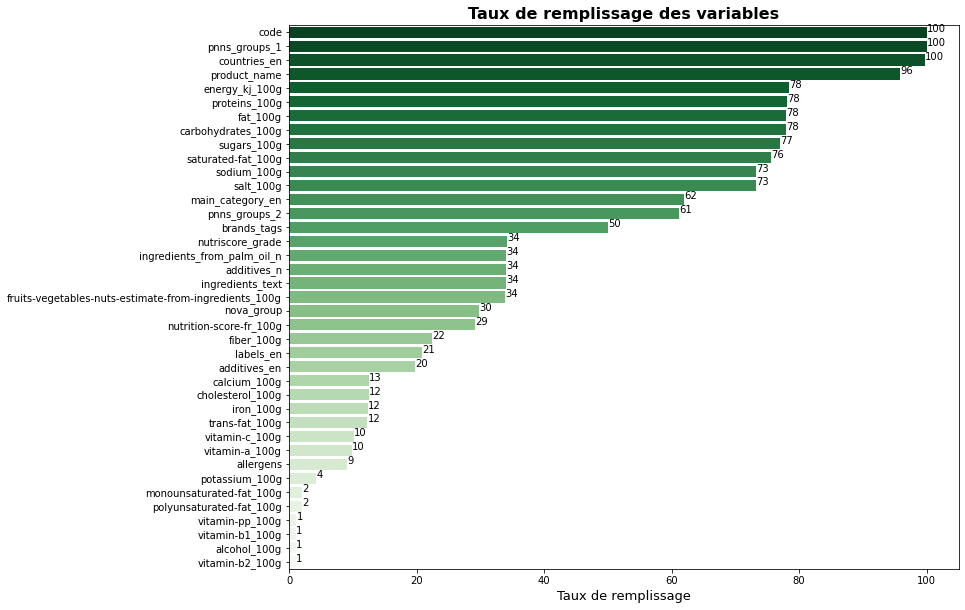

In [282]:
not_nan_percent = round(openfoodfacts_nan.notna().mean().sort_values(ascending = False),4)*100

plt.figure(figsize=(12, 10))
ax = sns.barplot(y = not_nan_percent.index, x = not_nan_percent.values, palette = 'Greens_r')
plt.title("Taux de remplissage des variables")
plt.ylabel("")
plt.xlabel("Taux de remplissage")
etiquette_h(ax)
# plt.axvline(x = 20, color = 'r');
#plt.text(42, -1, '>40%', color='r');

### Suppression des lignes où aucun nutriment / product_name / pnns_groups_2 ne sont renseignés

Nous allons supprimer les observations pour lesquelles aucune variable qui se termine par 100g n'est renseignée et celles où le product_name ne figure pas.

In [294]:
# Liste des variables qui se terminent par 100g
liste_col_100g = openfoodfacts_nan.columns[openfoodfacts_nan.columns.str.contains('_100g')]
liste_col_100g

Index(['energy_kj_100g', 'fat_100g', 'saturated-fat_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'alcohol_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g',
       'potassium_100g', 'calcium_100g', 'iron_100g',
       'fruits-vegetables-nuts-estimate-from-ingredients_100g',
       'nutrition-score-fr_100g'],
      dtype='object')

In [295]:
# Index les lignes pour lesquelles aucun nutriment n'est renseigné
index_nan = openfoodfacts_nan.loc[openfoodfacts_nan[liste_col_100g].isna().all(axis=1), :].index

In [296]:
# Suppression des lignes
openfoodfacts_nan = openfoodfacts_nan.drop(index_nan, axis = 0, inplace = False)

In [297]:
# Index les lignes pour lesquelles le product_name n'est pas renseigné
index_product_name_nan = openfoodfacts_nan[openfoodfacts_nan['product_name'].isna()].index

In [298]:
# Suppression des lignes
openfoodfacts_nan = openfoodfacts_nan.drop(index_product_name_nan, axis = 0, inplace = False)

In [302]:
# Index les lignes pour lesquelles le pnns_groups_2 n'est pas renseigné
index_pnns_groups_2_nan = openfoodfacts_nan[openfoodfacts_nan['pnns_groups_2'].isna()].index

In [303]:
# Suppression des lignes
openfoodfacts_nan = openfoodfacts_nan.drop(index_pnns_groups_2_nan, axis = 0, inplace = False)

In [304]:
shape_total_nan(openfoodfacts_nan)

Nombre de lignes: 1066416
Nombre de colonnes: 39
Nombre total de NaN du dataset: 19930054
% total de NaN du dataset: 47.92%


### Constante pour les variables qualitatives identifiant les aliments et les variables additives_en, labels_en et allergens <a class="anchor" id="nan_constante"></a>

Lorsque les valeurs ne sont pas renseignées, nous complèterons les données par la valeur 'unknown' permettant d'identifier que le champ n'a pas été rempli et par la valeur 'None' illustrant le fait qu'il est normal que la valeur soit vide. L'équivalent quantitatif serait la mention 0.

In [305]:
# Colonnes impactées
col_constante = not_nan_percent[not_nan_percent.index.str.contains('pnns|category|brands|text')].index
col_constante

Index(['pnns_groups_1', 'main_category_en', 'pnns_groups_2', 'brands_tags',
       'ingredients_text'],
      dtype='object')

In [306]:
# Imputation des variables par la constante unknown
openfoodfacts_nan[col_constante] = openfoodfacts_nan[col_constante].fillna('unknown')

In [307]:
# Imputation des variables par la constante none
openfoodfacts_nan[['additives_en', 'labels_en', 'allergens']] = openfoodfacts_nan[['additives_en', 'labels_en', 
                                                                                   'allergens']].fillna('none')

In [308]:
shape_total_nan(openfoodfacts_nan)

Nombre de lignes: 1066416
Nombre de colonnes: 39
Nombre total de NaN du dataset: 16604239
% total de NaN du dataset: 39.92%


### 0 pour les variables de compte <a class="anchor" id="nan_0"></a>

Nous partons du principe ici que les valeurs non renseignées sont égales à 0.

In [309]:
# Colonnes impactées
col_0 = not_nan_percent[not_nan_percent.index.str.endswith('_n')].index
col_0

Index(['ingredients_from_palm_oil_n', 'additives_n'], dtype='object')

In [310]:
# Imputation des variables par 0
openfoodfacts_nan[col_0] = openfoodfacts_nan[col_0].fillna(0)

In [311]:
shape_total_nan(openfoodfacts_nan)

Nombre de lignes: 1066416
Nombre de colonnes: 39
Nombre total de NaN du dataset: 15618987
% total de NaN du dataset: 37.55%


### Médiane pour les variables quantitatives remplies au minimum à 70% <a class="anchor" id="nan_med"></a>

Nous allons affecter la médiane de chaque pnns_groups_2 aux variables sélectionnées. En effet les modalités de ce groupe permettent de bien caractériser les types d'aliments et le nombre de modalités n'est ni trop faible ni trop important.

In [312]:
# Colonnes impactées
col_med = not_nan_percent[(not_nan_percent >= 70) & 
                          (not_nan_percent < 100) & 
                          (not_nan_percent.index.str.endswith('100g'))].index
col_med

Index(['energy_kj_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'saturated-fat_100g', 'sodium_100g', 'salt_100g'],
      dtype='object')

In [313]:
# Imputation des variables energy_kj_100g, proteins_100g, fat_100g, carbohydrates_100g,  sugars_100g et
# saturated-fat_100g par la médiane par modalités de la variable pnns_groups_2
for col in col_med:
    openfoodfacts_nan[col].fillna(openfoodfacts_nan.groupby('pnns_groups_2')[col].transform('median'), inplace=True)

In [314]:
shape_total_nan(openfoodfacts_nan)

Nombre de lignes: 1066416
Nombre de colonnes: 39
Nombre total de NaN du dataset: 14971579
% total de NaN du dataset: 36.0%


### Mode pour les variables qualitatives remplies au minimum à 70% hors variables identifiant les aliments <a class="anchor" id="nan_mode"></a>

Nous allons affecter le mode de la variable countries_en dans sa globalité.

In [315]:
# Colonnes impactées
col_mode = not_nan_percent[(not_nan_percent >= 70) & 
                          (not_nan_percent < 100) & 
                          (~not_nan_percent.index.str.contains('100g|product|pnns|category'))].index
col_mode

Index(['countries_en'], dtype='object')

In [316]:
# Imputation des variables countries_en par le mode
openfoodfacts_nan['countries_en'] = openfoodfacts_nan['countries_en'].fillna(
        openfoodfacts_nan['countries_en'].mode().iloc[0])

In [317]:
shape_total_nan(openfoodfacts_nan)

Nombre de lignes: 1066416
Nombre de colonnes: 39
Nombre total de NaN du dataset: 14969754
% total de NaN du dataset: 35.99%


### Iterative imputer pour les variables corrélées entre-elles <a class="anchor" id="nan_iterative"></a>

Nous allons tracer la matrice de corrélation afin de repérer les variables corrélées entre elles à plus de 50%.

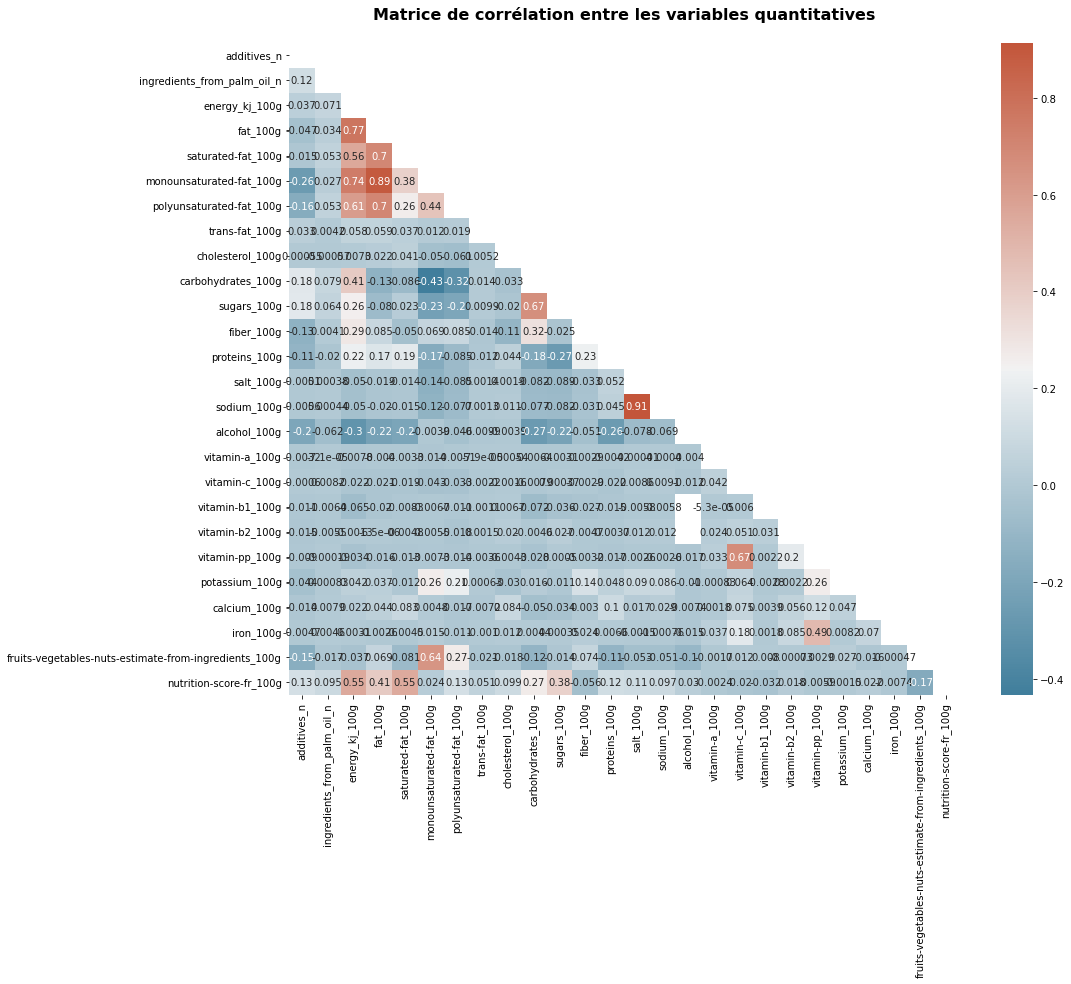

In [318]:
# Corrélation
corr = openfoodfacts_nan.corr()

# Création d'un masque
mask = np.triu(corr)

# Taille du graph
plt.subplots(figsize=(15,12))

# Colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Heatmap avec masque

sns.heatmap(corr, annot = True, mask = mask, cmap=cmap)
plt.title("Matrice de corrélation entre les variables quantitatives\n", fontsize=16);

Les variables corrélées entre elles à plus de 50% sont:

- monounsaturated-fat_100g avec energy_kj_100g et fat_100g
- polyunsaturated-fat_100g avec energy_kj_100g et fat_100g
- fruits-vegetables-nuts-estimate-from-ingredients_100g avec monounsaturated-fat_100g
- nutriscore_score avec saturated-fat_100g et energy_kj_100g
- vitamin-pp_100g et vitamin-c_100g


Nous allons appliquer l'iterative imputer pour chaque groupe de variables. Lorsque les valeurs seront inférieures à 0, nous les remplacerons par 0.

Pour les variables vitamin-pp_100g et vitamin-c_100g remplies respectivement à seulement 1% et 12%, nous prendrons comme stratégie de les compléter par la médiane en fonction des pnns_groups_2 afin de ne pas rajouter de bruit.

In [319]:
def iterative_imputer_function(df_var):
    imp_mean = IterativeImputer(random_state=0)
    X = np.array(df_var)
    imp_mean.fit(X)
    result = imp_mean.transform(X)
    
    return result

#### monounsaturated-fat_100g avec energy_kj_100g et fat_100g

In [320]:
iterative_imputer_function(openfoodfacts_nan[['monounsaturated-fat_100g', 'energy_kj_100g', 'fat_100g']])

array([[-8.10167465e-01,  3.89000000e+02,  1.39999998e+00],
       [ 2.67979893e+00,  9.36000000e+02,  8.19999981e+00],
       [-1.51903343e+00,  2.64000000e+02,  0.00000000e+00],
       ...,
       [ 9.23496336e+00,  1.39300000e+03,  2.02000008e+01],
       [ 2.34279942e+00,  9.25000000e+02,  7.59999990e+00],
       [ 1.13930273e+00,  5.48000000e+02,  5.00000000e+00]])

In [321]:
# affectation des résultats de l'algorithme dans les variables concernées
openfoodfacts_nan['monounsaturated-fat_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['monounsaturated-fat_100g', 'energy_kj_100g', 'fat_100g']])[:,0]

openfoodfacts_nan['energy_kj_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['monounsaturated-fat_100g', 'energy_kj_100g', 'fat_100g']])[:,1]

openfoodfacts_nan['fat_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['monounsaturated-fat_100g', 'energy_kj_100g', 'fat_100g']])[:,2]

In [322]:
# iterative imputer
#imp_mean = IterativeImputer(random_state=0)
#X = np.array(openfoodfacts_nan[['monounsaturated-fat_100g', 'energy_kj_100g', 'fat_100g']])
#imp_mean.fit(X)
#result = imp_mean.transform(X)

#openfoodfacts_nan['monounsaturated-fat_100g'] = result[:,0]
#openfoodfacts_nan['energy_kj_100g'] = result[:,1]
#openfoodfacts_nan['fat_100g'] = result[:,2]

#### polyunsaturated-fat_100g avec energy_kj_100g et fat_100g

In [323]:
# affectation des résultats de l'algorithme dans les variables concernées
openfoodfacts_nan['polyunsaturated-fat_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['polyunsaturated-fat_100g', 'energy_kj_100g', 'fat_100g']])[:,0]

openfoodfacts_nan['energy_kj_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['polyunsaturated-fat_100g', 'energy_kj_100g', 'fat_100g']])[:,1]

openfoodfacts_nan['fat_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['polyunsaturated-fat_100g', 'energy_kj_100g', 'fat_100g']])[:,2]

#### fruits-vegetables-nuts-estimate-from-ingredients_100g avec monounsaturated-fat_100g

In [324]:
# affectation des résultats de l'algorithme dans les variables concernées
openfoodfacts_nan['fruits-vegetables-nuts-estimate-from-ingredients_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['fruits-vegetables-nuts-estimate-from-ingredients_100g', 'monounsaturated-fat_100g']])[:,0]

openfoodfacts_nan['monounsaturated-fat_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['fruits-vegetables-nuts-estimate-from-ingredients_100g', 'monounsaturated-fat_100g']])[:,1]

#### nutriscore_score avec saturated-fat_100g et energy_kj_100g

In [325]:
openfoodfacts_nan['nutrition-score-fr_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['nutrition-score-fr_100g', 'saturated-fat_100g', 'energy_kj_100g']])[:,0]

openfoodfacts_nan['saturated-fat_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['nutrition-score-fr_100g', 'saturated-fat_100g', 'energy_kj_100g']])[:,1]

openfoodfacts_nan['energy_kj_100g'] = iterative_imputer_function(
    openfoodfacts_nan[['nutrition-score-fr_100g', 'saturated-fat_100g', 'energy_kj_100g']])[:,2]

#### vitamin-pp_100g et vitamin-c_100g

In [326]:
openfoodfacts_nan['vitamin-pp_100g'].fillna(openfoodfacts_nan.groupby('pnns_groups_2')[col].transform('median'), 
                                            inplace=True)

openfoodfacts_nan['vitamin-c_100g'].fillna(openfoodfacts_nan.groupby('pnns_groups_2')[col].transform('median'), 
                                           inplace=True)

Pour toutes les valeurs manquantes qui ont été remplies par des valeurs inférieures à 0 (outliers) , nous allons les remplacer par 0.

In [327]:
col_iterative = ['monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'nutrition-score-fr_100g', 
                'saturated-fat_100g']

for col in col_iterative:
    openfoodfacts_nan[col] = np.where(openfoodfacts_nan[col] < 0, 0, openfoodfacts_nan[col])

In [328]:
shape_total_nan(openfoodfacts_nan)

Nombre de lignes: 1066416
Nombre de colonnes: 39
Nombre total de NaN du dataset: 9992235
% total de NaN du dataset: 24.03%


### Knn pour les autres variables quantitatives <a class="anchor" id="nan_knn"></a>

C’est un algorithme qui peut servir autant pour la classification que pour la régression. Il est surnommé « nearest neighbors » (plus proches voisins, en français) car le principe de ce modèle consiste en effet à choisir les k données les plus proches du point étudié afin d’en prédire sa valeur.

In [329]:
# Colonnes impactées
col_knn = ['fiber_100g', 'calcium_100g', 'cholesterol_100g', 'iron_100g','trans-fat_100g', 'vitamin-a_100g', 
           'potassium_100g', 'vitamin-b1_100g','vitamin-b2_100g', 'alcohol_100g']

In [330]:
#imputer = KNNImputer(n_neighbors=3)
#imputed = imputer.fit_transform(openfoodfacts_nan[col_knn])
#imputed

Le KNN étant adapté aux petits jeux de données car très consommateur en ressources, nous complèterons les dernières valeurs manquantes des variables quantitatives par la médiane de chaque pnns_groups_2.

In [331]:
# Imputation des variables par la médiane par pnns_groups_2
for col in col_knn:
    openfoodfacts_nan[col].fillna(openfoodfacts_nan.groupby('pnns_groups_2')[col].transform('median'), inplace=True)

In [338]:
round(openfoodfacts_nan.notna().mean().sort_values(ascending = False),4)*100

code                                                     100.0
vitamin-a_100g                                           100.0
carbohydrates_100g                                       100.0
sugars_100g                                              100.0
fiber_100g                                               100.0
proteins_100g                                            100.0
salt_100g                                                100.0
sodium_100g                                              100.0
alcohol_100g                                             100.0
vitamin-c_100g                                           100.0
trans-fat_100g                                           100.0
vitamin-b1_100g                                          100.0
vitamin-b2_100g                                          100.0
vitamin-pp_100g                                          100.0
potassium_100g                                           100.0
calcium_100g                                           

In [337]:
# On remplace les dernières valeurs manquantes par 0
openfoodfacts_nan[col_knn] = openfoodfacts_nan[col_knn].fillna(0)

### Knn pour les nova_group et le nutriscore_grade <a class="anchor" id="nan_knn_quali"></a>

In [ ]:
a = pd.DataFrame(list(openfoodfacts_nan['nutriscore_grade']))
le = LabelEncoder()

fit_by = pd.Series([i for i in a.iloc[:,0].unique() if type(i) == str])
le.fit(fit_by)

nutri_transformed = []

for nutri in openfoodfacts_nan['nutriscore_grade']:
    x = nutri
    if type(nutri) == str:
        x = le.transform([nutri])[0]
    nutri_transformed.append(x)

In [ ]:
# Création dataframe avec variables et nutriscore
openfoodfacts_nan_knn = openfoodfacts_nan[['proteins_100g', 'fiber_100g', 
                                           'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'energy_kj_100g', 
                                           'saturated-fat_100g', 'sugars_100g', 'salt_100g']]

openfoodfacts_nan_knn['nutriscore_transformed'] = pd.Series(nutri_transformed)

imputer = KNNImputer(n_neighbors=3)
imputed = imputer.fit_transform(openfoodfacts_nan_knn)
imputed

Encore une fois, le jeu de données est beaucoup trop important pour appliquer un Knn. Nous allons donc opter pour une méthode alternative, remplacer les valeurs manquantes par la constante 'unknown'.

In [335]:
# Imputation des variables par la constante unknown
openfoodfacts_nan['nutriscore_grade'] = openfoodfacts_nan['nutriscore_grade'].fillna('unknown')
openfoodfacts_nan['nova_group'] = openfoodfacts_nan['nova_group'].fillna('unknown')

In [339]:
shape_total_nan(openfoodfacts_nan)

Nombre de lignes: 1066416
Nombre de colonnes: 39
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


### Traitement des outliers

Nous allons appliquer les traitements précédents sur les valeurs aberrantes dans le cas où l'imputation des valeurs manquantes notamment à l'aide d'algorithmes en aurait généré de nouvelles. Nous supprimerons les observations incohérentes.

In [344]:
# Copie du dataset
openfoodfacts_clean = openfoodfacts_nan.copy()

In [359]:
def clean_outliers(data):
    
    # Valeurs supérieures à 100 et inférieures à 0
    liste_col_nutriments = data.columns[(data.columns.str.contains('_100g')) & 
                               (~data.columns.str.contains(
                                   'energy'))]
    for col in liste_col_nutriments:
        data = data[data[col].between(0, 100)]
        
    # Valeurs des variables qui rentrent dans la composition d'une autre variable
    liste_col_fat = ['saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g', 
                     'trans-fat_100g', 'cholesterol_100g']
    liste_col_carbo = ['sugars_100g', 'fiber_100g']
    liste_col_salt = ['sodium_100g']
    
    # Traitement des lipides
    fat_sup = data['fat_100g'] < (data[liste_col_fat].sum(axis='columns'))
    data = data[~fat_sup]
    
    # Traitement des glucides
    carbo_sup = data['carbohydrates_100g'] < (data[liste_col_carbo].sum(axis='columns'))
    data = data[~carbo_sup]
    
    # Traitement du sel
    salt_sup = data['salt_100g'] < (data[liste_col_salt].sum(axis='columns'))
    data = data[~salt_sup]
    
    # Somme des nutriments supérieures à 100
    liste_col_nutriments = ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'salt_100g', 'alcohol_100g', 
                        'vitamin-a_100g', 'vitamin-c_100g', 'vitamin-b1_100g', 'vitamin-b2_100g', 
                        'vitamin-pp_100g', 'potassium_100g', 'calcium_100g', 'iron_100g']
    sum_nutriments = data[liste_col_nutriments].sum(axis='columns') > 100
    data = data[~sum_nutriments]
    
    #Calories supérieures à 900 ou kilojoules supérieurs à 3 766
    energy_kj = data['energy_kj_100g'] > 3766
    data = data[~energy_kj]
    
    return data

In [362]:
openfoodfacts_clean = clean_outliers(openfoodfacts_clean)

In [363]:
shape_total_nan(openfoodfacts_clean)

Nombre de lignes: 633600
Nombre de colonnes: 39
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


Le dataset ne contenant plus aucune valeur manquante, nous allons l'enregistrer au format .csv afin de le réutiliser dans la partie 'Exploration' du projet.

Pour rappel, ce jeu de données nettoyé ne contient plus de doublons, de valeurs aberrantes et les données manquantes ont été soit supprimées, soit complétées de différentes manières (mode, médiane par pnns_groups_2, constante, 0 ou des algorithmes tels que l'iterative imputer (le Knn n'a pas fonctionné, le jeu de données étant trop important).

In [368]:
# Export csv
openfoodfacts_clean.to_csv('data/openfoodfacts_clean.csv')

## Sélection des variables en lien avec le choix d'application <a class="anchor" id="select"></a>

L'agence "Santé publique France" a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. Consommatrice de soupes, surtout en cette période hivernale, je suis régulièrement confrontée à un choix difficile. **Quelle est la soupe qui serait la moins salée mais également la moins sucrée et la moins grasse?**

La grande diversité de produits proposés en rayon rend ce choix compliqué. En analysant les étiquettes on se rend vite compte que la présence d'un label ou d'un conditionnement plus naturel n'est pas gage de qualité nutritionnelle.

Je souhaite contribuer à l'appel à projets en proposant une application permettant de recommander une alternative pour une même catégorie de produit. L'utilisateur prend en photo le code barre ce qui permet de récupérer la catégorie du produit, ses ingrédients et qualités nutritionnelles et de proposer une alternative, si besoin est, de meilleure qualité de la même catégorie.

Nous nous focaliserons ici sur les **produits vendus en France** afin de réduire la taille du dataset et d'améliorer les performances de nos algorithmes.

Les variables suivantes seront nécessaires pour notre application:
- **code**: code barre qui servira à identifier le produit lorsque l'utilisateur le prendra en photo
- **product_name**: nom du produit pour vérifier si la référence est correcte
- **brands_tags**: marque du produit
- **pnns_groups_2**: catégorie du produit
- **fat_100g**: évaluer la quantité de lipides
- **carbohydrates_100g**: évaluer la quantité de glucides
- **salt_100g**: évaluer la quantité de sel

In [ ]:
# Copie du dataset
openfoodfacts_clean = openfoodfacts_nan.copy()

In [ ]:
# Filtre sur les produits vendus en France
openfoodfacts_clean = openfoodfacts_clean[openfoodfacts_clean['countries_en'].str.contains(
    'france|frankreich|french|francia|francja|frankrijk|franța|franca', na = False)]

In [ ]:
# Sélection des colonnes pertinentes
openfoodfacts_clean = openfoodfacts_clean[['code', 'product_name', 'brands_tags', 'pnns_groups_2', 
                                             'fat_100g', 'carbohydrates_100g', 'salt_100g']]

In [ ]:
# Export csv
openfoodfacts_clean.to_csv('data/openfoodfacts_clean.csv')

[Retour à la table des matières](#0)